# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


0

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [73]:
Mode9 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode9/Mode9.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode9.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [74]:
GLOBAL_SAVE_CALIBRATE = true;

In [75]:
Mode9.Stuff["op_drive_params"]

Dict{String, Any} with 16 entries:
  "q_ef_3"     => Dict{String, Any}("pulse_time"=>93.125, "Envelope Args"=>Dict…
  "q_half_ge0" => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_2"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1/2"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "sb_f2g3"    => Dict{String, Any}("pulse_time"=>214.053, "Envelope Args"=>Dic…
  "sb_f1g2"    => Dict{String, Any}("pulse_time"=>259.303, "Envelope Args"=>Dic…
  "q_ge_4/3"   => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_3"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ef_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_0"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dic…
  "q_ge_1"     => Dict{String, Any}("pulse_time"=>92.9688, "Envelope Args"

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [12]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-10 20:03:27] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-10 20:03:50] Info: Done With Floquet Sweep


Progress:  18%|███████▌                                 |  ETA: 0:00:01

[2024-11-10 20:03:52] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00036021736095103173	 0.008955030057129743	 2.0067009030121494
Stark shift res: [0.00036021736095103173, 55.648095549423644]


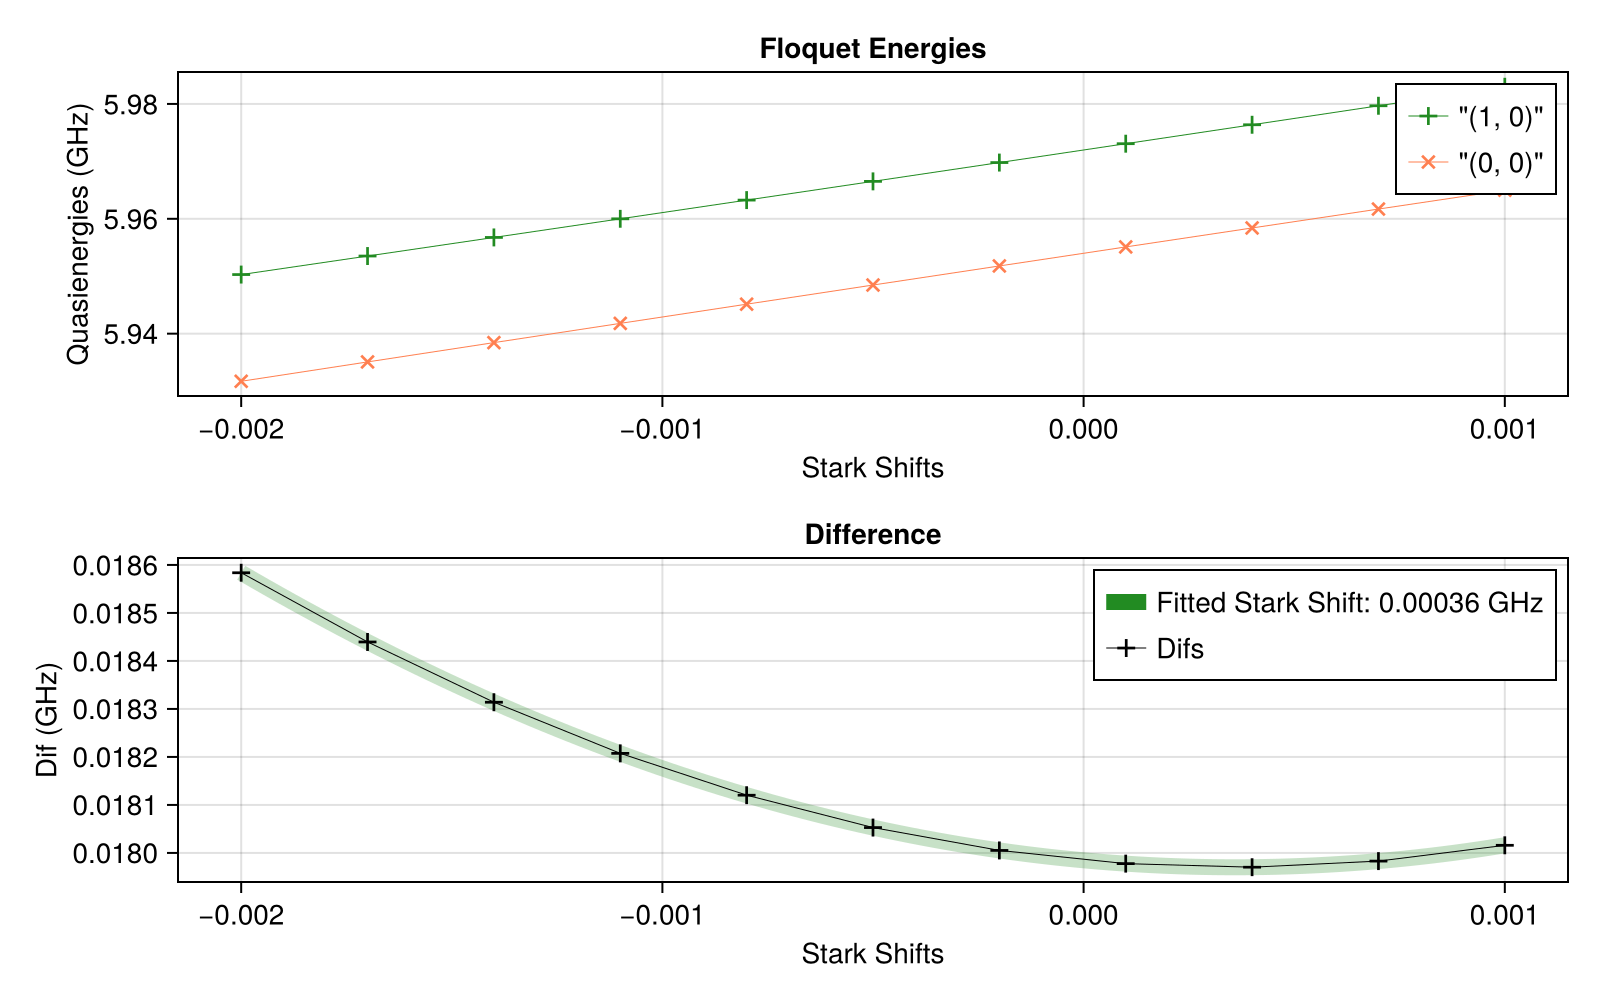

In [ ]:
ge_ε = 0.00538
drive_op = Mode9.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode9, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [ ]:

ψ1 = Mode9.dressed_states[(1,0)]+Mode9.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode9.dressed_states[(0,0)]+Mode9.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode9.dressed_energies[(1,0)]-Mode9.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode9.dressed_energies[(1,1)]-Mode9.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 20:04:14] Info: On Level 1
[2024-11-10 20:04:14] Info: On Step 1: t = 90.0
[2024-11-10 20:04:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 20:04:21] Info: Time Evolution Complete
[2024-11-10 20:04:21] Info: Done with Level_1_step_1
[2024-11-10 20:04:21] Info: Using Check Op
[2024-11-10 20:04:21] Info: Accurace: 0.997107535410674
[2024-11-10 20:04:21] Info: ------------------------------------------------------------------------------
[2024-11-10 20:04:21] Info: On Step 2: t = 92.5
[2024-11-10 20:04:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:04:25] Info: Time Evolution Complete
[2024-11-10 20:04:25] Info: Done with Level_1_step_2
[2024-11-10 20:04:25] Info: Using Check Op
[2024-11-10 20:04:25] Info: Accurace: 0.9995479367263939
[2024-11-10 20:04:25] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99961
  "freq_d"        => 4.60399

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99961
  "freq_d"        => 4.60399

In [ ]:
ψ = Mode9.dressed_states[(1,0)]+Mode9.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:05:56.539
It is being saved at: Data/
[2024-11-10 20:05:56] Info: Running operator q_ge_1/2
[2024-11-10 20:05:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 20:06:03] Info: Time Evolution Complete
[2024-11-10 20:06:03] Info: Saving Steps
[2024-11-10 20:06:12] Info: Done with Step_1
[2024-11-10 20:06:12] Info: Done With Running Sequence
[2024-11-10 20:06:12] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [17]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-10 20:06:18] Info: Making Plot


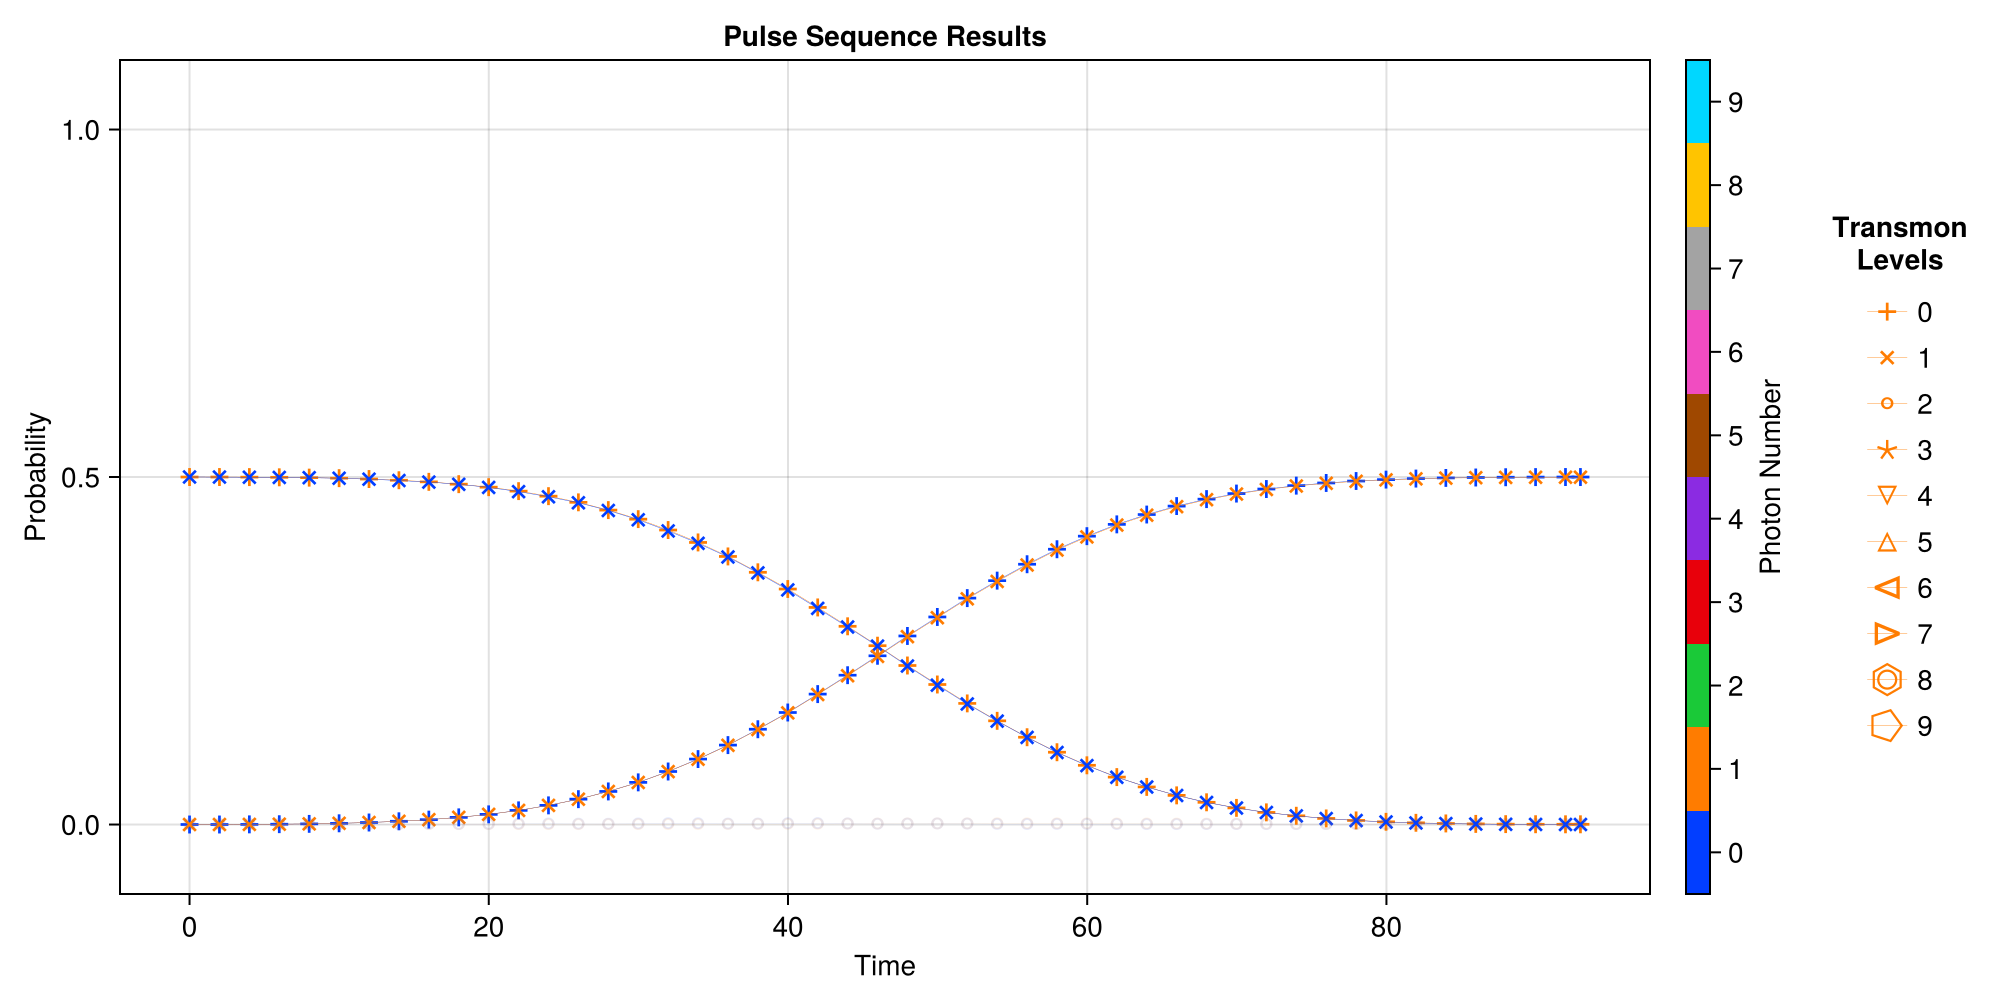

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [19]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.499949625097175 - 2.4000862294681915e-17im
0.49968533383441516 + 2.480184146734979e-17im


In [20]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997375176823 + 8.823391834406822e-19im

#### $|0,0\rangle \to |1,0\rangle$

In [ ]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:06:29] Info: On Level 1
[2024-11-10 20:06:29] Info: On Step 1: t = 90.0
[2024-11-10 20:06:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:06:32] Info: Time Evolution Complete
[2024-11-10 20:06:32] Info: Done with Level_1_step_1
[2024-11-10 20:06:32] Info: Accurace: 0.9970833235286963
[2024-11-10 20:06:32] Info: ------------------------------------------------------------------------------
[2024-11-10 20:06:32] Info: On Step 2: t = 92.5
[2024-11-10 20:06:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:06:36] Info: Time Evolution Complete
[2024-11-10 20:06:36] Info: Done with Level_1_step_2
[2024-11-10 20:06:36] Info: Accurace: 0.9995258289673458
[2024-11-10 20:06:36] Info: ------------------------------------------------------------------------------
[2024-11-10 20:06:36] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999588
  "freq_d"        => 4.60406

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999588
  "freq_d"        => 4.60406

In [ ]:
ψ = Mode9.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:08:02.441
It is being saved at: Data/
[2024-11-10 20:08:02] Info: Running operator q_ge_0
[2024-11-10 20:08:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-10 20:08:09] Info: Time Evolution Complete
[2024-11-10 20:08:09] Info: Saving Steps
[2024-11-10 20:08:10] Info: Done with Step_1
[2024-11-10 20:08:10] Info: Done With Running Sequence
[2024-11-10 20:08:10] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-10 20:08:10] Info: Making Plot


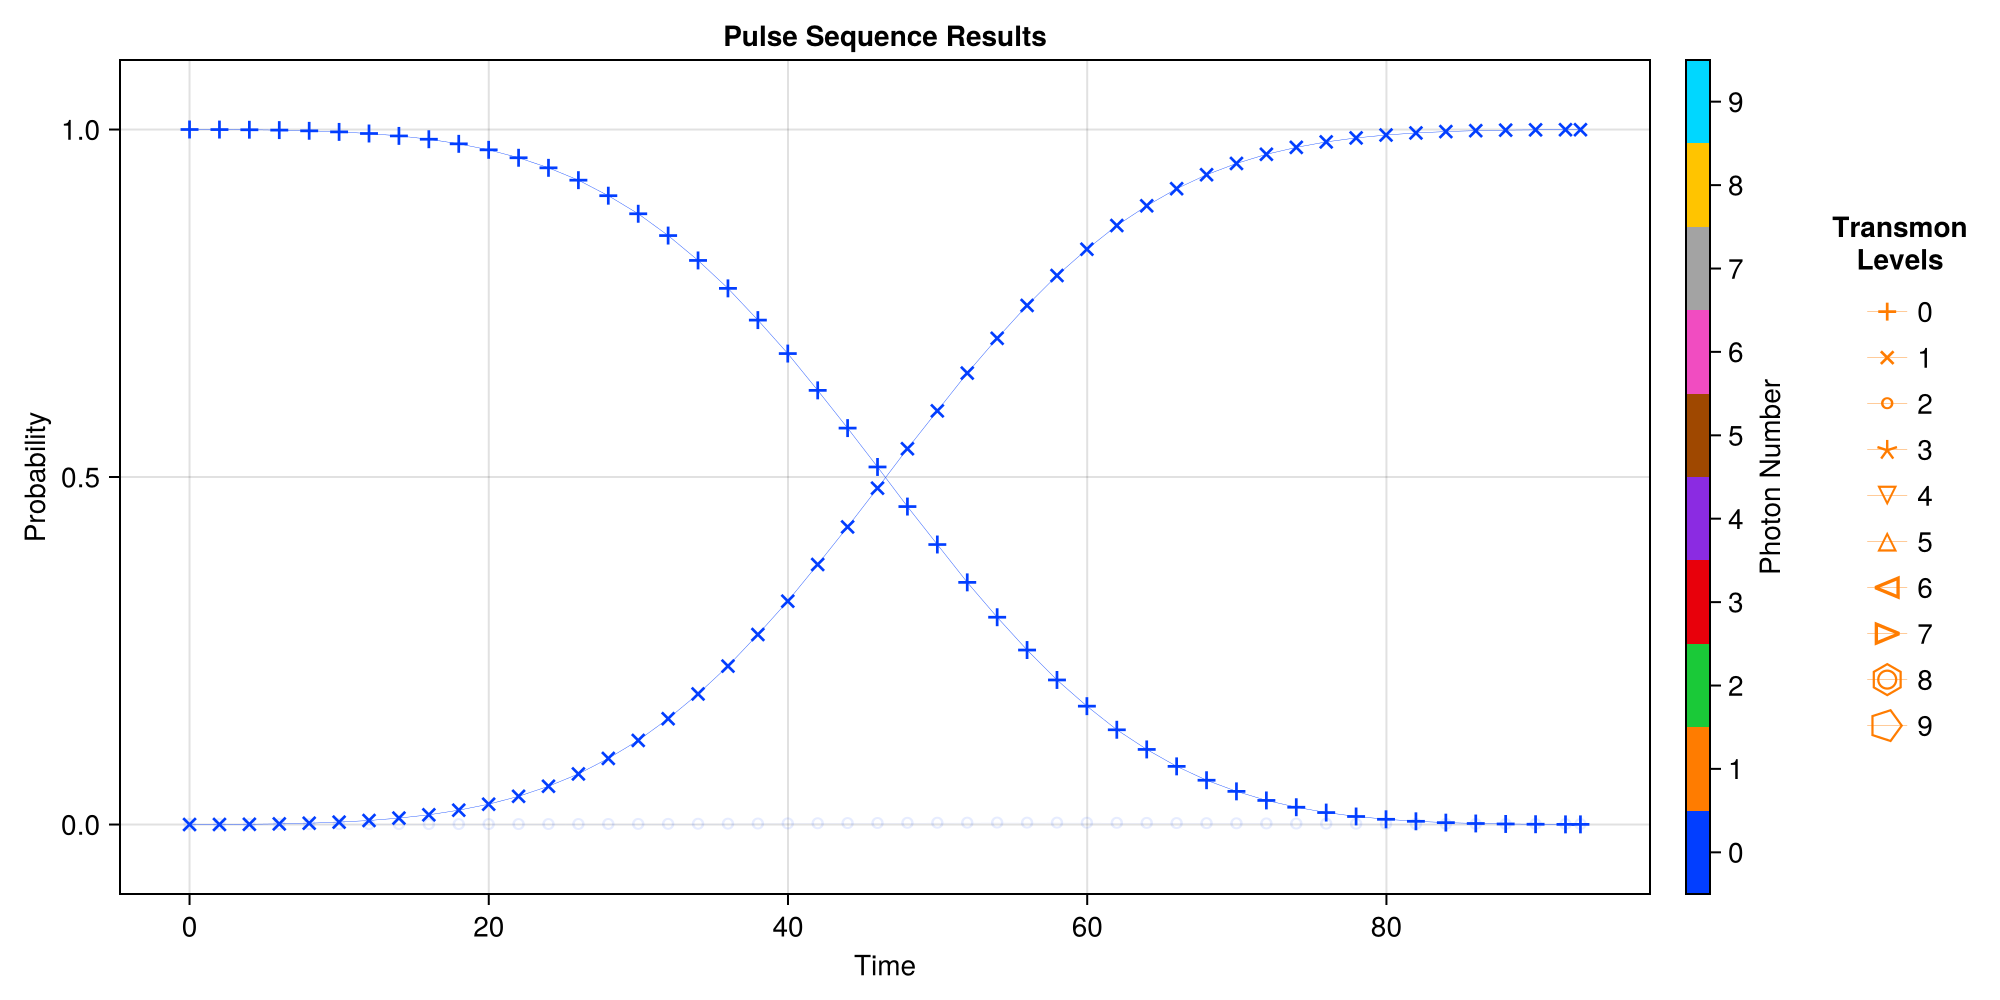

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [26]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022510656745512134 + 3.042115855451994e-21im
0.9997124859822394 - 6.830846796281213e-17im
6.20019583045186e-5 - 7.939202507774196e-21im


In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997375176823 + 8.823391834406822e-19im

#### $|0,1\rangle \to |1,1\rangle$

In [ ]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:08:11] Info: On Level 1
[2024-11-10 20:08:11] Info: On Step 1: t = 90.0
[2024-11-10 20:08:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:08:14] Info: Time Evolution Complete
[2024-11-10 20:08:14] Info: Done with Level_1_step_1
[2024-11-10 20:08:14] Info: Accurace: 0.997201700380857
[2024-11-10 20:08:14] Info: ------------------------------------------------------------------------------
[2024-11-10 20:08:14] Info: On Step 2: t = 92.5
[2024-11-10 20:08:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:08:18] Info: Time Evolution Complete
[2024-11-10 20:08:18] Info: Done with Level_1_step_2
[2024-11-10 20:08:18] Info: Accurace: 0.9996482410696996
[2024-11-10 20:08:18] Info: ------------------------------------------------------------------------------
[2024-11-10 20:08:18] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999711
  "freq_d"        => 4.60393

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999711
  "freq_d"        => 4.60393

In [ ]:
ψ = Mode9.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:09:46.207
It is being saved at: Data/
[2024-11-10 20:09:46] Info: Running operator q_ge_1
[2024-11-10 20:09:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:09:49] Info: Time Evolution Complete
[2024-11-10 20:09:49] Info: Saving Steps
[2024-11-10 20:09:50] Info: Done with Step_1
[2024-11-10 20:09:50] Info: Done With Running Sequence
[2024-11-10 20:09:50] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-10 20:09:50] Info: Making Plot


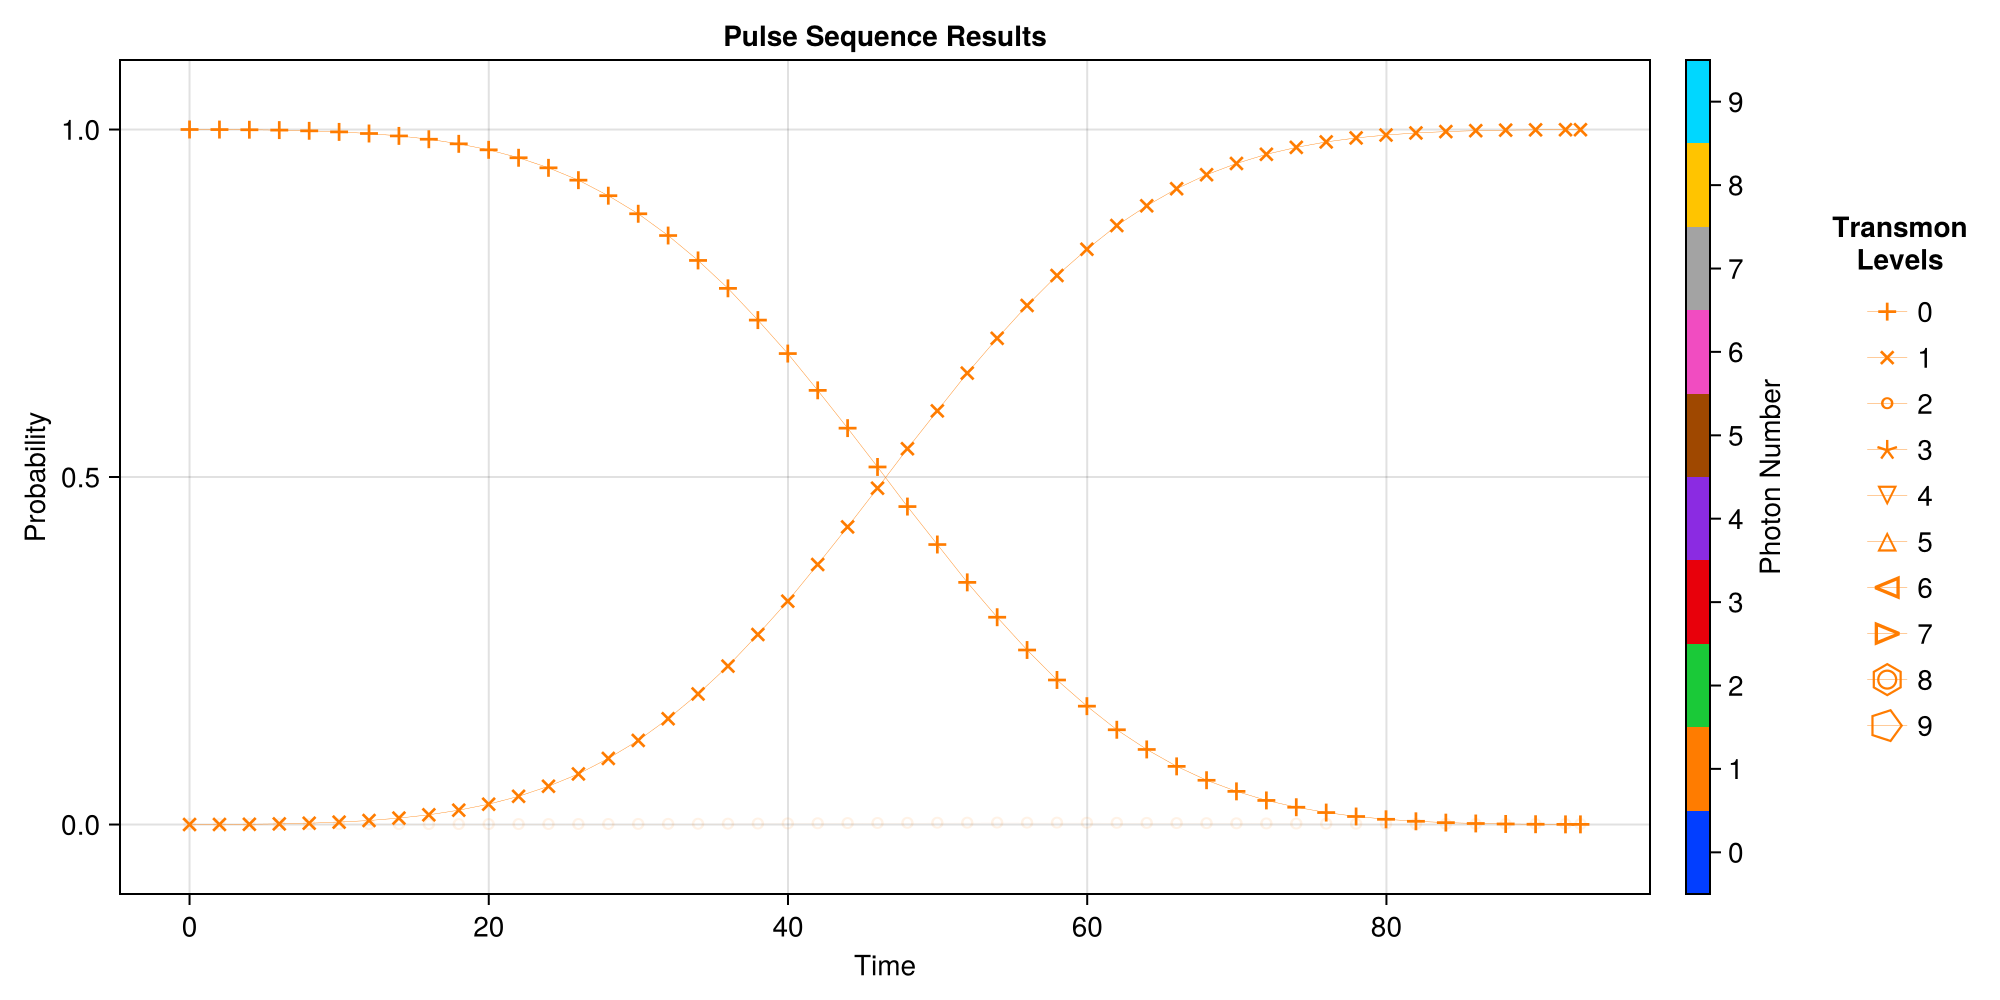

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [33]:
EVs[(1,1)][end]

0.9997110067356888 + 9.89680941868648e-17im

In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999980528312647 + 9.928759903281864e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [ ]:

ψ1 = Mode9.dressed_states[(0,0)]+(Mode9.dressed_states[(1,1)]+Mode9.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode9.dressed_states[(1,0)]+(Mode9.dressed_states[(0,1)]+Mode9.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode9.dressed_energies[(1,0)]-Mode9.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode9.dressed_energies[(1,1)]-Mode9.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode9.dressed_energies[(1,3)]-Mode9.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-10 20:09:51] Info: On Level 1
[2024-11-10 20:09:51] Info: On Step 1: t = 90.0
[2024-11-10 20:09:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:09:54] Info: Time Evolution Complete
[2024-11-10 20:09:54] Info: Done with Level_1_step_1
[2024-11-10 20:09:54] Info: Using Check Op
[2024-11-10 20:09:54] Info: Accurace: 0.9968444581662077
[2024-11-10 20:09:54] Info: ------------------------------------------------------------------------------
[2024-11-10 20:09:54] Info: On Step 2: t = 92.5
[2024-11-10 20:09:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-10 20:09:58] Info: Time Evolution Complete
[2024-11-10 20:09:58] Info: Done with Level_1_step_2
[2024-11-10 20:09:58] Info: Using Check Op
[2024-11-10 20:09:58] Info: Accurace: 0.9992686881345285
[2024-11-10 20:09:58] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999327
  "freq_d"        => 4.60389

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999327
  "freq_d"        => 4.60389

In [ ]:
ψ = Mode9.dressed_states[(1,1)]+(Mode9.dressed_states[(0,0)]+Mode9.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:11:28.129
It is being saved at: Data/
[2024-11-10 20:11:28] Info: Running operator q_ge_4/3
[2024-11-10 20:11:28] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-10 20:11:33] Info: Time Evolution Complete
[2024-11-10 20:11:33] Info: Saving Steps
[2024-11-10 20:11:34] Info: Done with Step_1
[2024-11-10 20:11:34] Info: Done With Running Sequence
[2024-11-10 20:11:34] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-10 20:11:34] Info: Making Plot


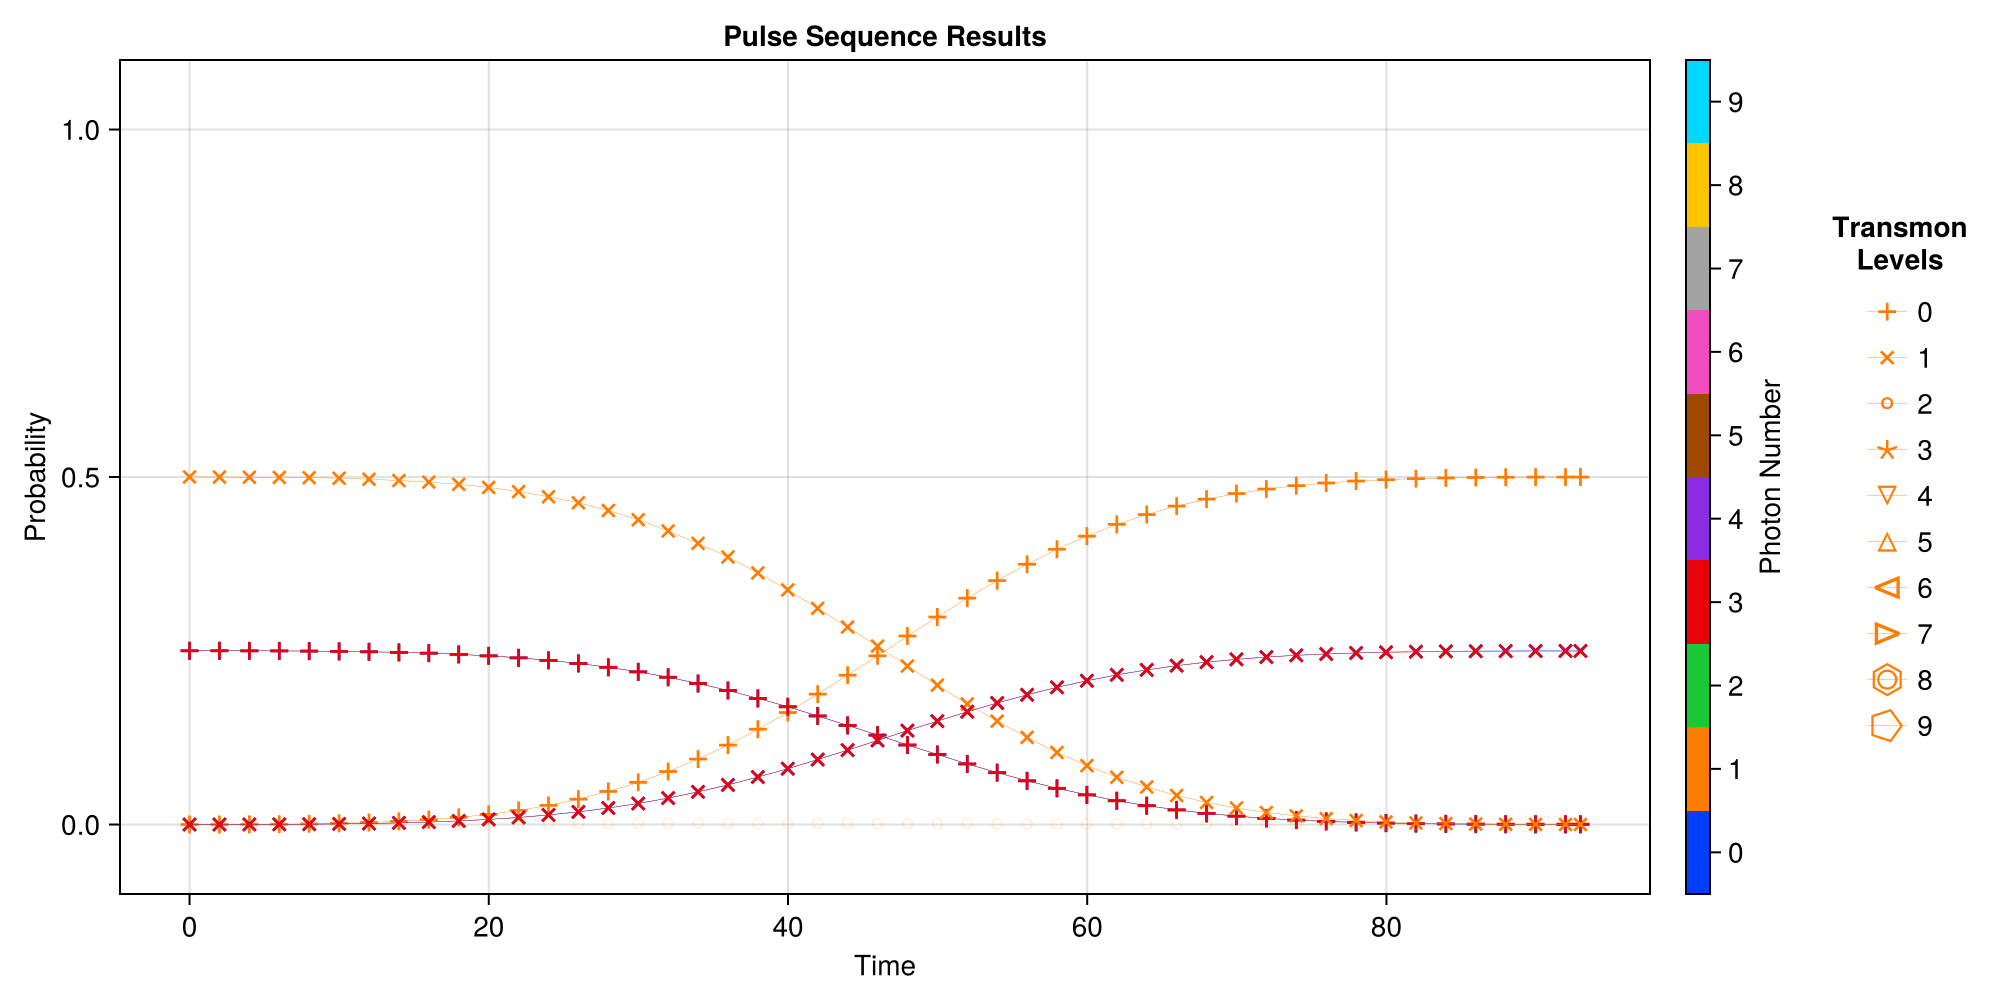

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [40]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49992734452637483 + 3.103310871510547e-17im
0.24996604817046786 - 2.526180506300049e-17im
0.24949203563517133 + 6.460280403245929e-18im


In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998289962891 + 1.216898458449419e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [ ]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:11:35] Info: On Level 1
[2024-11-10 20:11:35] Info: On Step 1: t = 90.0
[2024-11-10 20:11:35] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:11:38] Info: Time Evolution Complete
[2024-11-10 20:11:38] Info: Done with Level_1_step_1
[2024-11-10 20:11:38] Info: Accurace: 0.9972011477546155
[2024-11-10 20:11:38] Info: ------------------------------------------------------------------------------
[2024-11-10 20:11:38] Info: On Step 2: t = 92.5
[2024-11-10 20:11:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-10 20:11:42] Info: Time Evolution Complete
[2024-11-10 20:11:42] Info: Done with Level_1_step_2
[2024-11-10 20:11:42] Info: Accurace: 0.999649876414126
[2024-11-10 20:11:42] Info: ------------------------------------------------------------------------------
[2024-11-10 20:11:42] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.6038

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.6038

In [ ]:
ψ = Mode9.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:12:57.071
It is being saved at: Data/
[2024-11-10 20:12:57] Info: Running operator q_ge_2
[2024-11-10 20:12:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:12:59] Info: Time Evolution Complete
[2024-11-10 20:12:59] Info: Saving Steps
[2024-11-10 20:12:59] Info: Done with Step_1
[2024-11-10 20:12:59] Info: Done With Running Sequence
[2024-11-10 20:12:59] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-10 20:13:00] Info: Making Plot


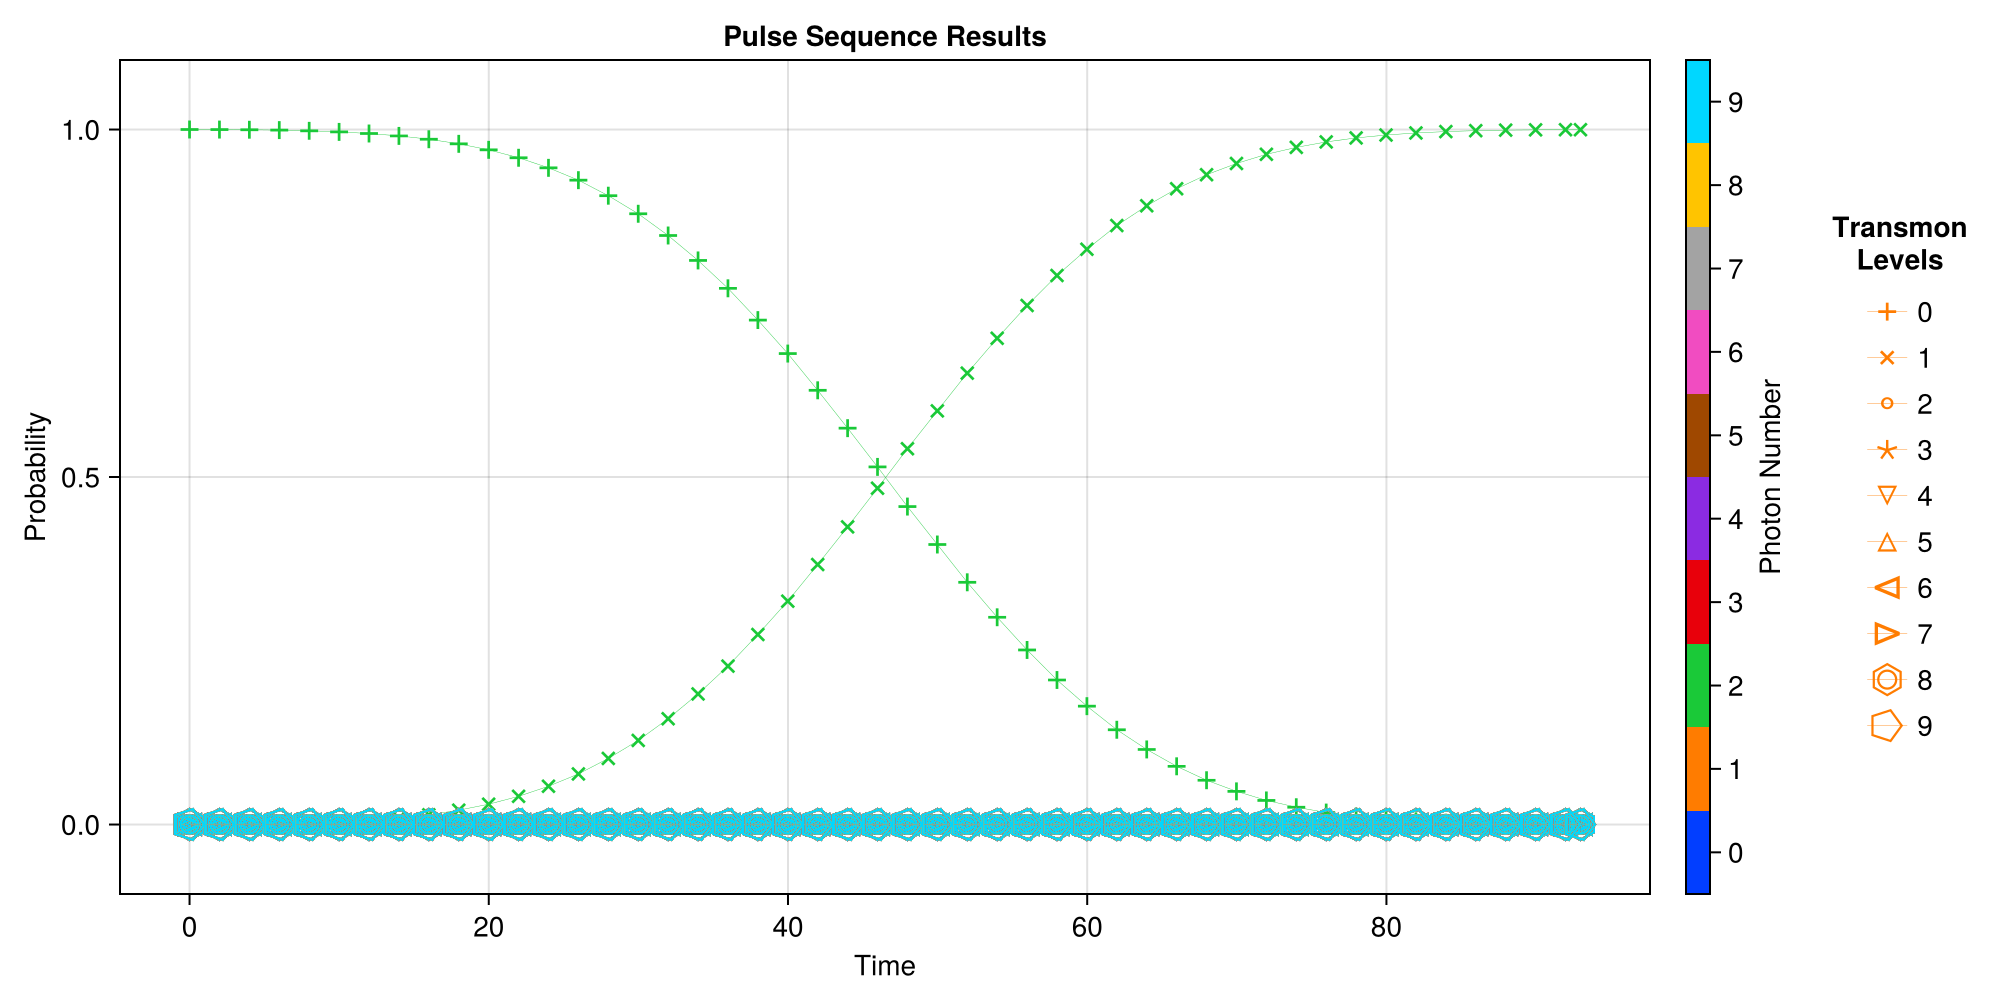

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge2_res["times"], EVs, plot_every = 10)

In [47]:
EVs[(1,2)][end]

0.9997129990197533 + 7.124622447413679e-17im

In [48]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999917868989 + 7.103532302137372e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [ ]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:13:00] Info: On Level 1
[2024-11-10 20:13:00] Info: On Step 1: t = 90.0
[2024-11-10 20:13:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:13:02] Info: Time Evolution Complete
[2024-11-10 20:13:02] Info: Done with Level_1_step_1
[2024-11-10 20:13:02] Info: Accurace: 0.9971984575926044
[2024-11-10 20:13:02] Info: ------------------------------------------------------------------------------
[2024-11-10 20:13:02] Info: On Step 2: t = 92.5
[2024-11-10 20:13:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:13:04] Info: Time Evolution Complete
[2024-11-10 20:13:04] Info: Done with Level_1_step_2
[2024-11-10 20:13:04] Info: Accurace: 0.9996494541374333
[2024-11-10 20:13:04] Info: ------------------------------------------------------------------------------
[2024-11-10 20:13:04] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60368

In [ ]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60368

In [ ]:
ψ = Mode9.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:13:54
It is being saved at: Data/
[2024-11-10 20:13:54] Info: Running operator q_ge_3
[2024-11-10 20:13:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:13:56] Info: Time Evolution Complete
[2024-11-10 20:13:56] Info: Saving Steps
[2024-11-10 20:13:57] Info: Done with Step_1
[2024-11-10 20:13:57] Info: Done With Running Sequence
[2024-11-10 20:13:57] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [52]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-10 20:13:57] Info: Making Plot


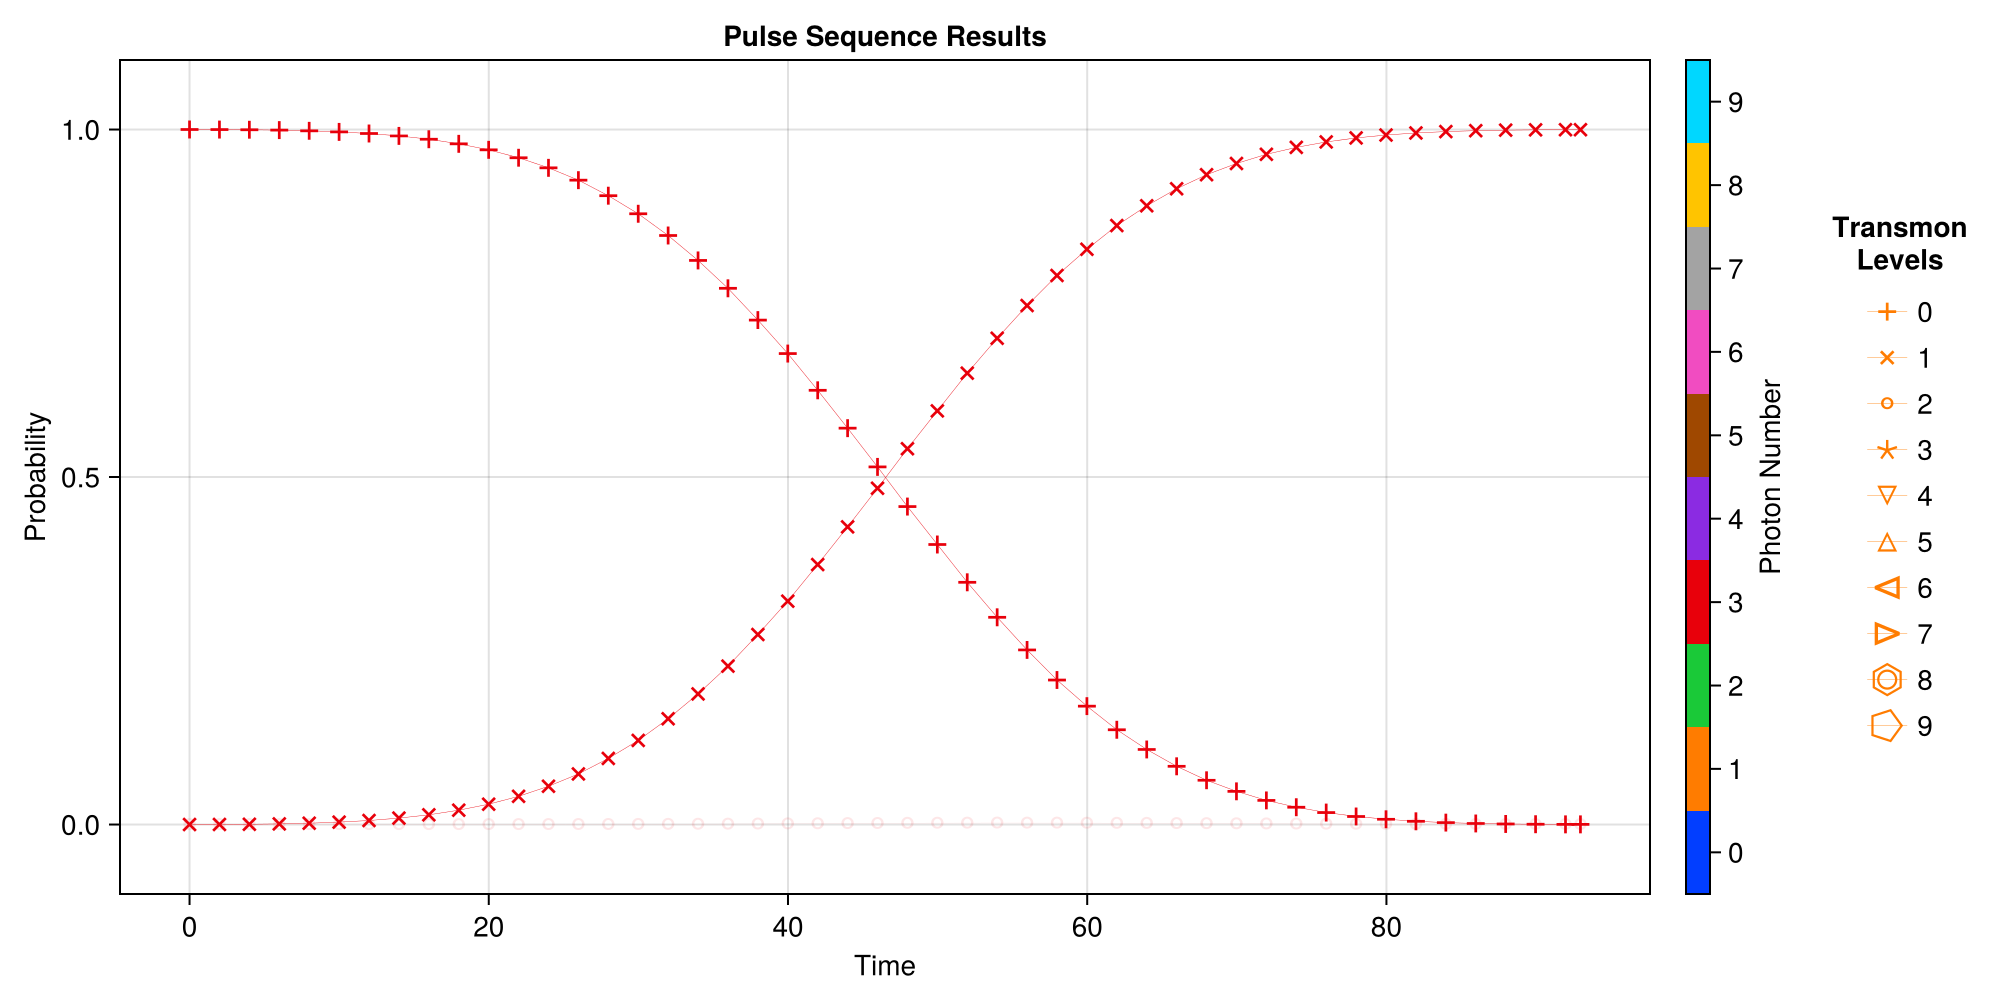

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [54]:
EVs[(1,3)][end]

0.9997130479329431 + 3.374455172317061e-17im

In [55]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999999845267 + 3.3914292513514164e-17im

### Guassian e -> f

In [56]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-10 20:13:57] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[2024-11-10 20:14:02] Info: Done With Floquet Sweep
[2024-11-10 20:14:02] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016522321690052918	 0.008957534460941842	 2.00628059693219
Stark shift res: [0.00016522321690052918, 55.64419185234795]


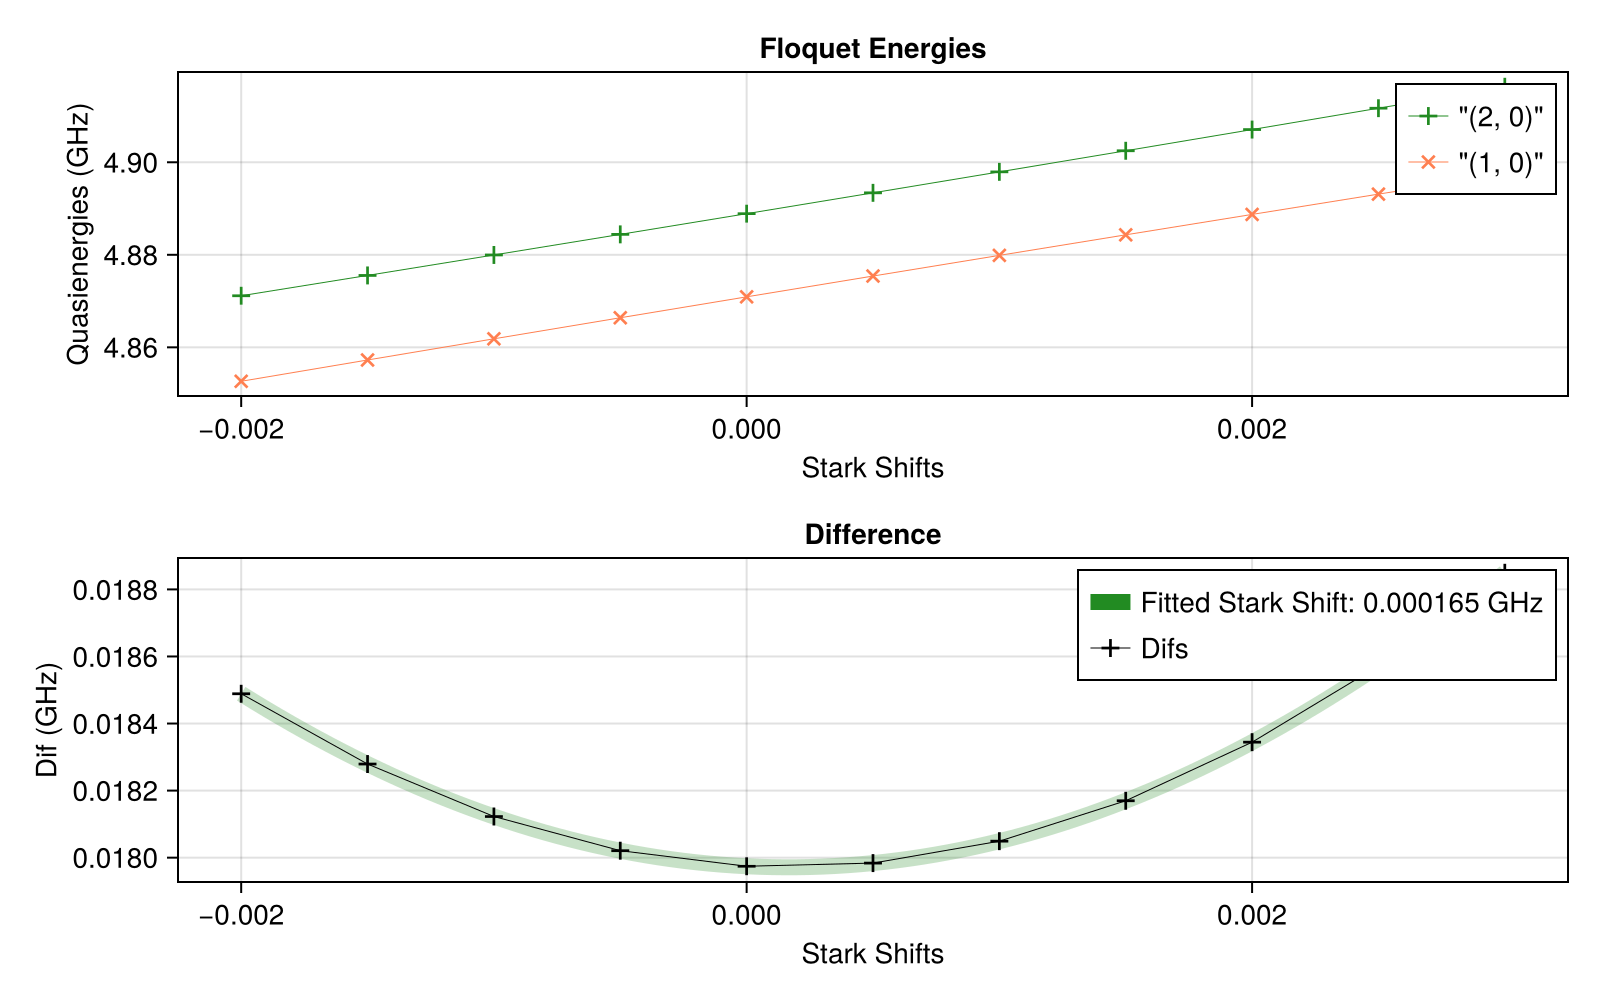

In [ ]:
ef_ε = 0.00385
drive_op = Mode9.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode9, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [ ]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:14:03] Info: On Level 1
[2024-11-10 20:14:03] Info: On Step 1: t = 90.0
[2024-11-10 20:14:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:14:04] Info: Time Evolution Complete
[2024-11-10 20:14:04] Info: Done with Level_1_step_1
[2024-11-10 20:14:04] Info: Accurace: 0.9973647380002136
[2024-11-10 20:14:04] Info: ------------------------------------------------------------------------------
[2024-11-10 20:14:04] Info: On Step 2: t = 92.5
[2024-11-10 20:14:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:14:06] Info: Time Evolution Complete
[2024-11-10 20:14:06] Info: Done with Level_1_step_2
[2024-11-10 20:14:06] Info: Accurace: 0.9998227458480301
[2024-11-10 20:14:06] Info: ------------------------------------------------------------------------------
[2024-11-10 20:14:06] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999884
  "freq_d"        => 4.49555

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999884
  "freq_d"        => 4.49555

In [ ]:
ψ = Mode9.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:14:58.468
It is being saved at: Data/
[2024-11-10 20:14:58] Info: Running operator q_ef_0
[2024-11-10 20:14:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:15:00] Info: Time Evolution Complete
[2024-11-10 20:15:00] Info: Saving Steps
[2024-11-10 20:15:01] Info: Done with Step_1
[2024-11-10 20:15:01] Info: Done With Running Sequence
[2024-11-10 20:15:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [61]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-10 20:15:01] Info: Making Plot


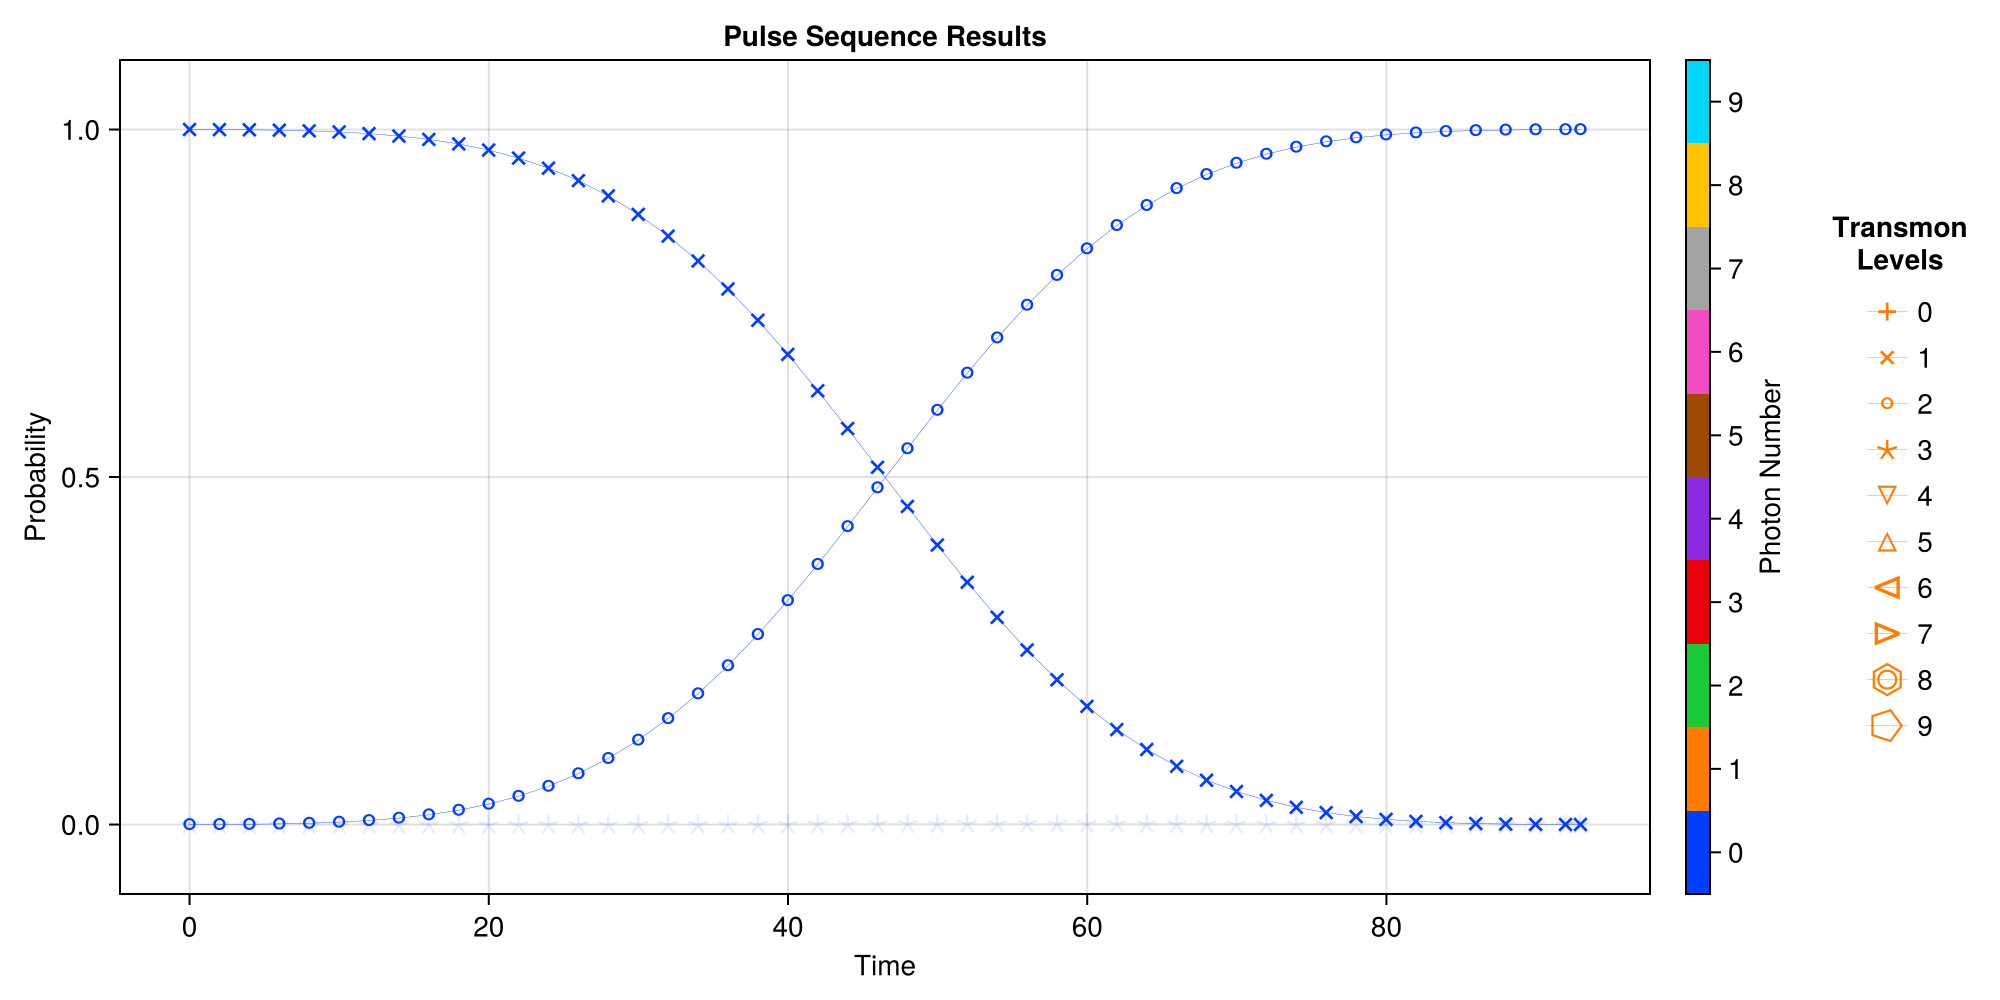

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [63]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5781359597031707e-5 - 3.725995562424298e-22im
4.683263402604799e-5 + 3.836437117641812e-21im
0.9998918339093466 + 7.750253983669887e-17im
4.287086090140953e-5 - 4.8216330960590605e-22im


In [64]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999973190197897 + 7.765113838996962e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [ ]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:15:02] Info: On Level 1
[2024-11-10 20:15:02] Info: On Step 1: t = 90.0
[2024-11-10 20:15:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:15:03] Info: Time Evolution Complete
[2024-11-10 20:15:03] Info: Done with Level_1_step_1
[2024-11-10 20:15:03] Info: Accurace: 0.9973729020038987
[2024-11-10 20:15:03] Info: ------------------------------------------------------------------------------
[2024-11-10 20:15:03] Info: On Step 2: t = 92.5
[2024-11-10 20:15:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:15:06] Info: Time Evolution Complete
[2024-11-10 20:15:06] Info: Done with Level_1_step_2
[2024-11-10 20:15:06] Info: Accurace: 0.9998325304644815
[2024-11-10 20:15:06] Info: ------------------------------------------------------------------------------
[2024-11-10 20:15:06] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49543

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49543

In [ ]:
ψ = Mode9.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:15:57.906
It is being saved at: Data/
[2024-11-10 20:15:57] Info: Running operator q_ef_1
[2024-11-10 20:15:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:15:59] Info: Time Evolution Complete
[2024-11-10 20:15:59] Info: Saving Steps
[2024-11-10 20:16:00] Info: Done with Step_1
[2024-11-10 20:16:00] Info: Done With Running Sequence
[2024-11-10 20:16:00] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-10 20:16:00] Info: Making Plot


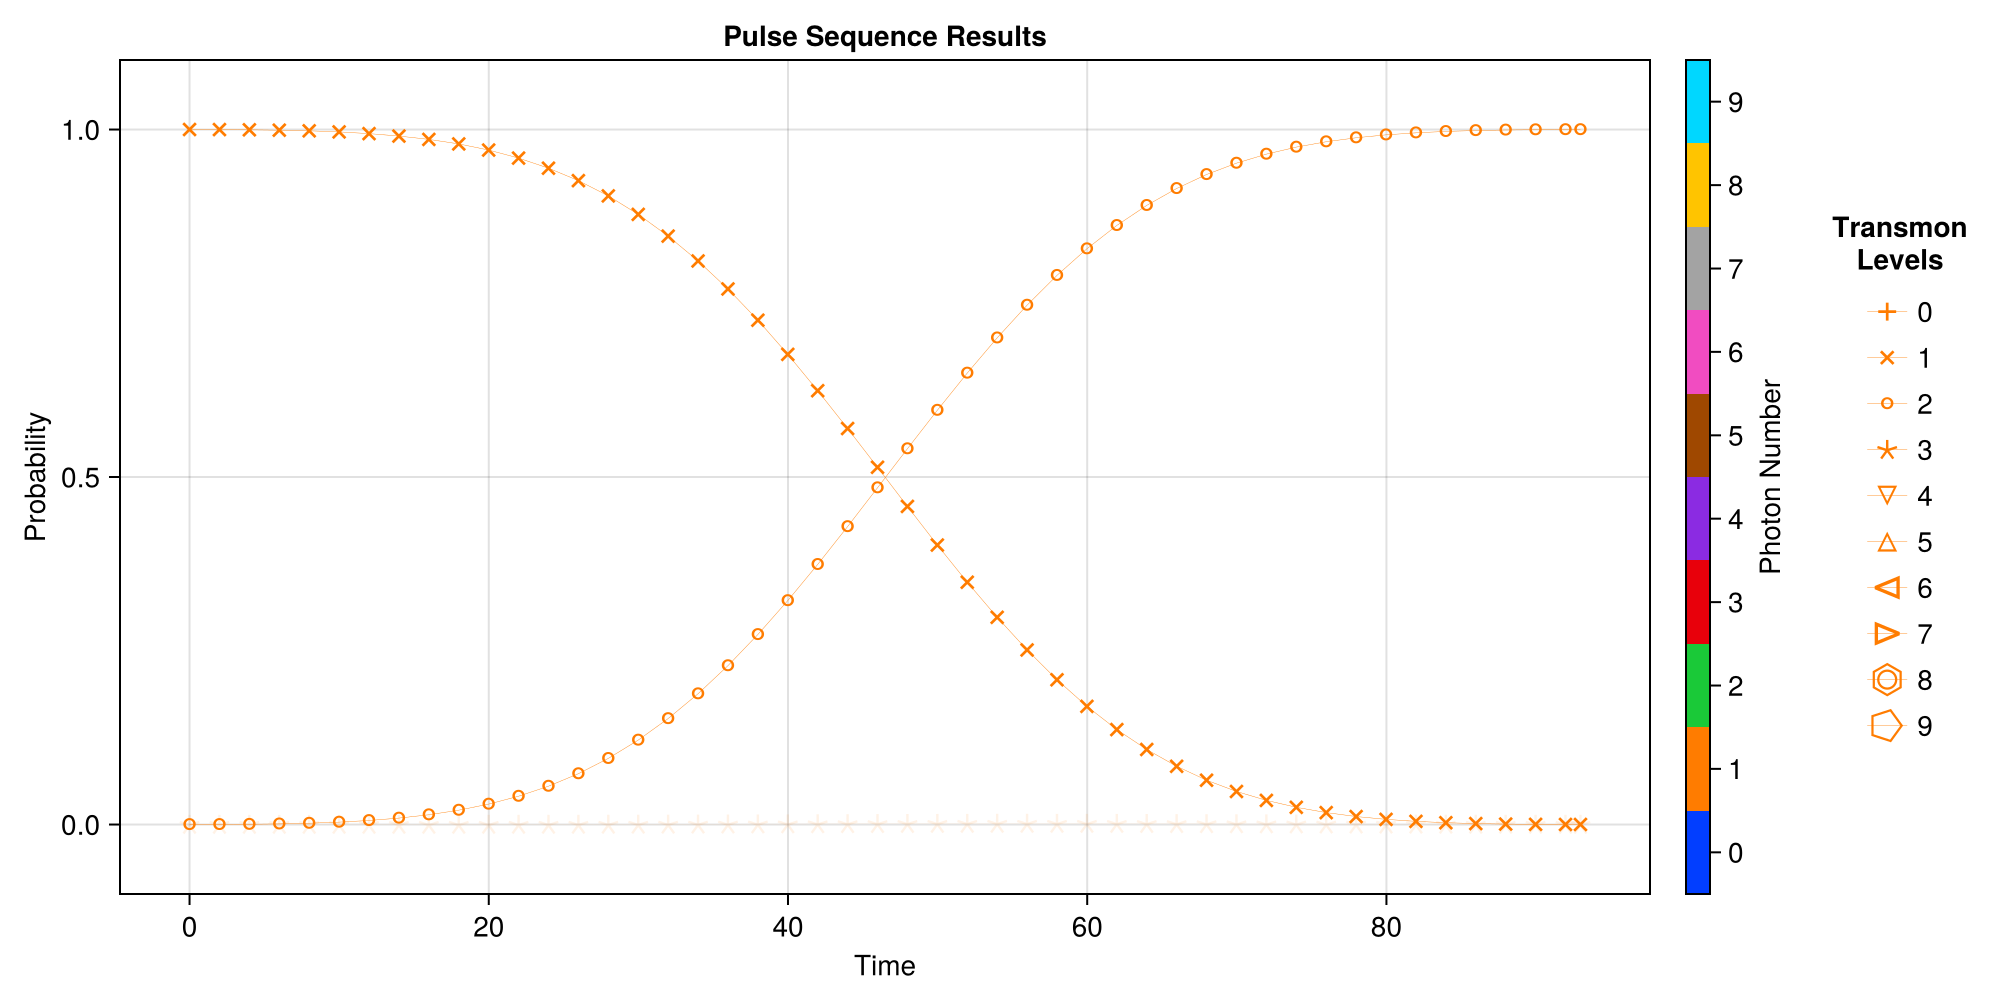

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [70]:
EVs[(2,1)][end]

0.9998944806666369 - 3.843286596917708e-17im

In [71]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999431206124 - 3.8440290514243737e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [ ]:
ψ1 = Mode9.dressed_states[(1,0)]/sqrt(2)+Mode9.dressed_states[(2,0)]+Mode9.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode9.dressed_states[(2,0)]+(Mode9.dressed_states[(1,0)]+Mode9.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode9.dressed_energies[(2,0)]-Mode9.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode9.dressed_energies[(2,1)]-Mode9.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode9.dressed_energies[(2,3)]-Mode9.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-10 20:16:00] Info: On Level 1
[2024-11-10 20:16:00] Info: On Step 1: t = 90.0
[2024-11-10 20:16:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:16:02] Info: Time Evolution Complete
[2024-11-10 20:16:02] Info: Done with Level_1_step_1
[2024-11-10 20:16:02] Info: Using Check Op
[2024-11-10 20:16:02] Info: Accurace: 0.9990969067807124
[2024-11-10 20:16:02] Info: ------------------------------------------------------------------------------
[2024-11-10 20:16:02] Info: On Step 2: t = 92.5
[2024-11-10 20:16:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:16:04] Info: Time Evolution Complete
[2024-11-10 20:16:04] Info: Done with Level_1_step_2
[2024-11-10 20:16:04] Info: Using Check Op
[2024-11-10 20:16:04] Info: Accurace: 0.9996349283281487
[2024-11-10 20:16:04] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999644
  "freq_d"        => 4.49537

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999644
  "freq_d"        => 4.49537

In [ ]:
ψ = Mode9.dressed_states[(1,0)]/sqrt(2)+Mode9.dressed_states[(2,0)]+Mode9.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:16:55.769
It is being saved at: Data/
[2024-11-10 20:16:55] Info: Running operator q_ef_3/2
[2024-11-10 20:16:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-10 20:16:58] Info: Time Evolution Complete
[2024-11-10 20:16:58] Info: Saving Steps
[2024-11-10 20:16:59] Info: Done with Step_1
[2024-11-10 20:16:59] Info: Done With Running Sequence
[2024-11-10 20:16:59] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [75]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-10 20:16:59] Info: Making Plot


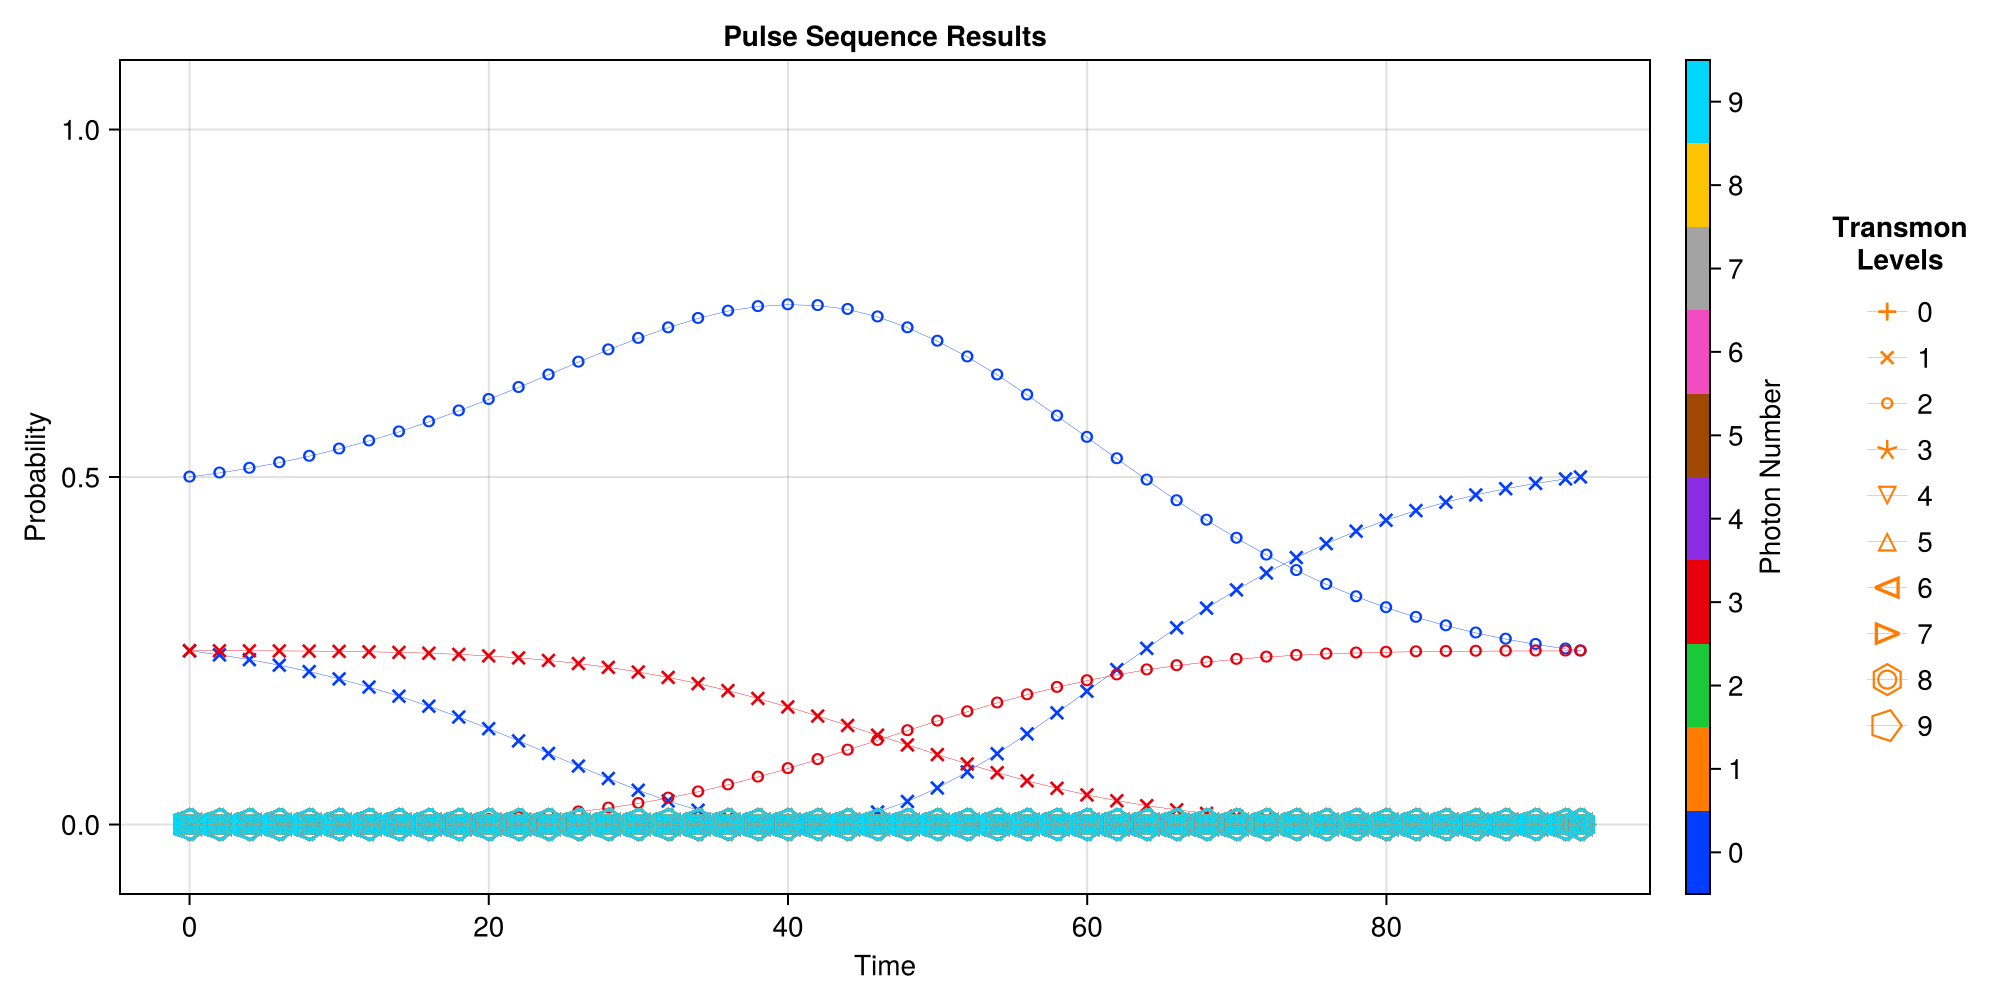

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [77]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24986273269651593 + 8.086343826399454e-18im
0.5000535189650119 - 5.693730718794617e-17im
0.24973125481777844 + 1.489301567954719e-17im


In [78]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998247557458 - 3.40935349214457e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [ ]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-10 20:16:59] Info: On Level 1
[2024-11-10 20:16:59] Info: On Step 1: t = 90.0
[2024-11-10 20:16:59] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:17:01] Info: Time Evolution Complete
[2024-11-10 20:17:01] Info: Done with Level_1_step_1
[2024-11-10 20:17:01] Info: Accurace: 0.9973712548156081
[2024-11-10 20:17:01] Info: ------------------------------------------------------------------------------
[2024-11-10 20:17:01] Info: On Step 2: t = 92.5
[2024-11-10 20:17:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:17:03] Info: Time Evolution Complete
[2024-11-10 20:17:03] Info: Done with Level_1_step_2
[2024-11-10 20:17:03] Info: Accurace: 0.9998322119476598
[2024-11-10 20:17:03] Info: ------------------------------------------------------------------------------
[2024-11-10 20:17:03] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.49531

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.49531

In [ ]:
ψ = Mode9.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:18:09.805
It is being saved at: Data/
[2024-11-10 20:18:09] Info: Running operator q_ef_2
[2024-11-10 20:18:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:18:11] Info: Time Evolution Complete
[2024-11-10 20:18:11] Info: Saving Steps
[2024-11-10 20:18:12] Info: Done with Step_1
[2024-11-10 20:18:12] Info: Done With Running Sequence
[2024-11-10 20:18:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [82]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-10 20:18:12] Info: Making Plot


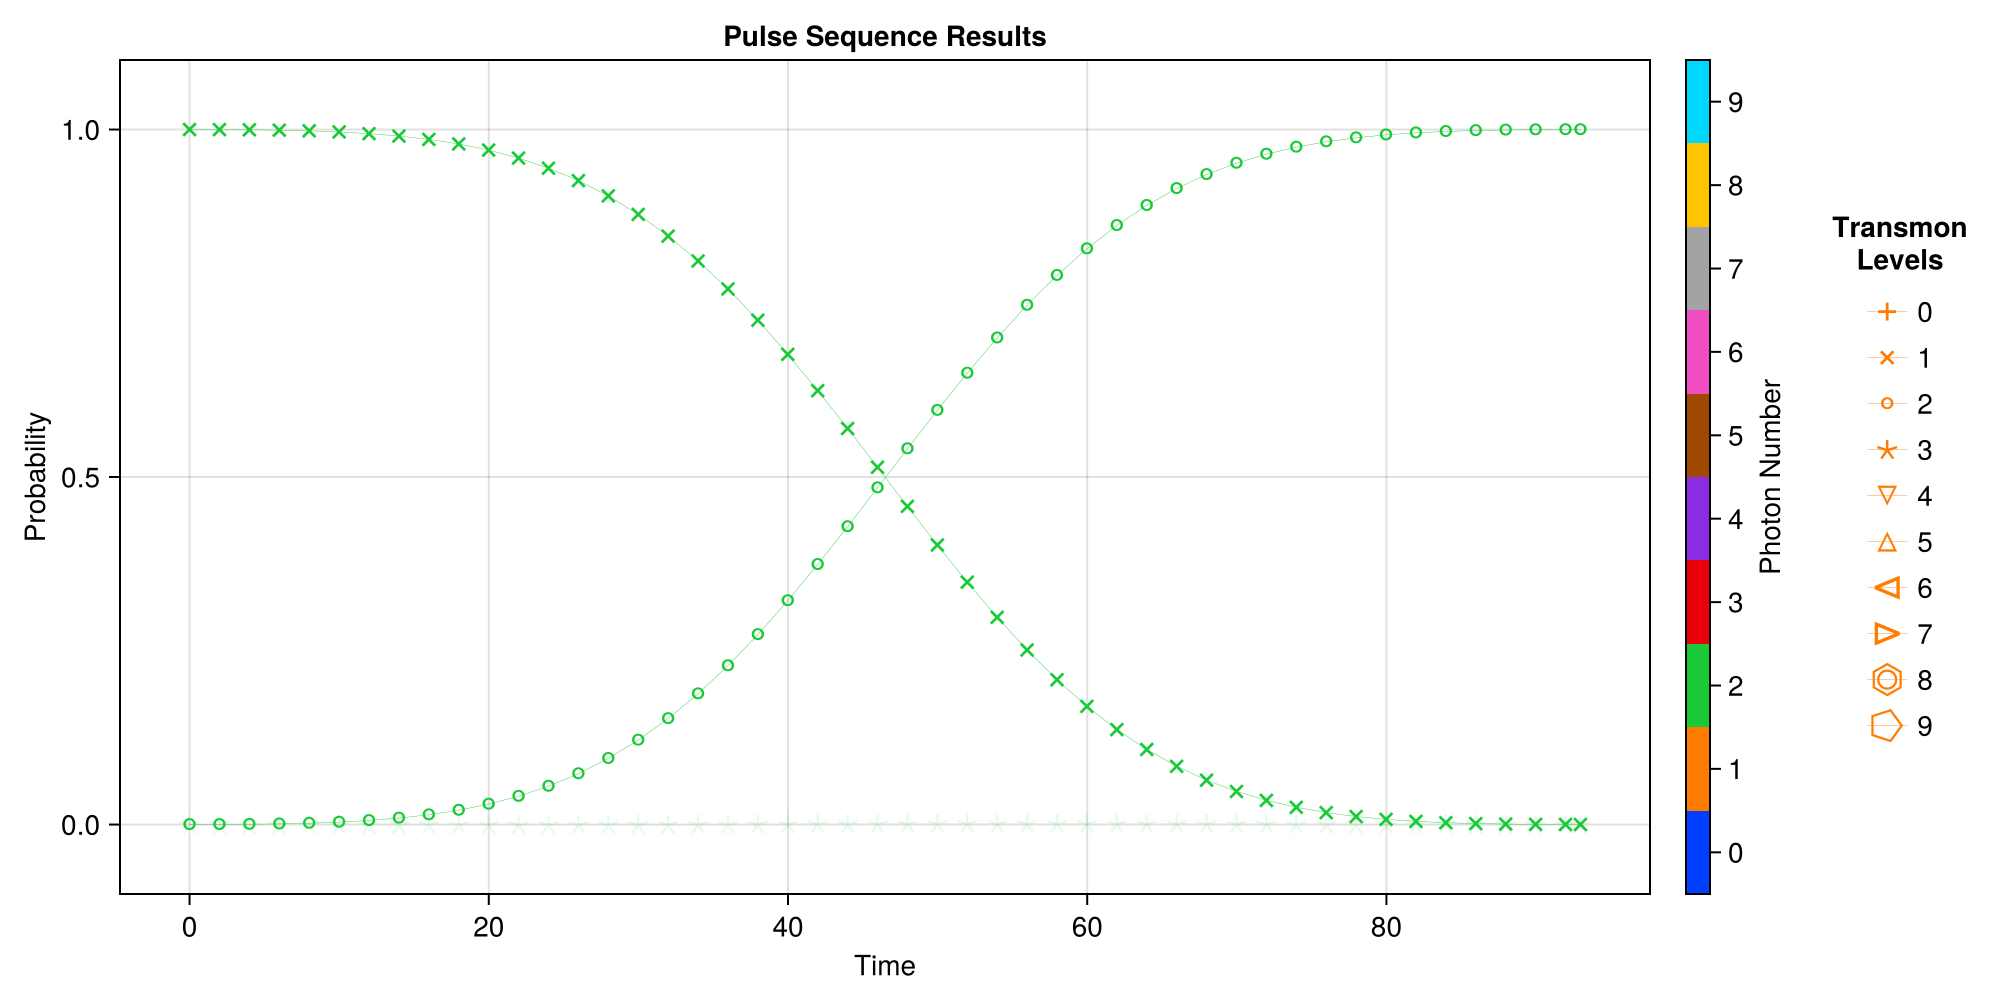

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [84]:
EVs[(2,2)][end]

0.9998945572926675 - 2.755010237047149e-17im

In [85]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999964592453 - 2.701206555279549e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [ ]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode9.dressed_states[state1]
ψ2 = Mode9.dressed_states[state2]

freq_d = Mode9.dressed_energies[state2]-Mode9.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-10 20:18:12] Info: On Level 1
[2024-11-10 20:18:12] Info: On Step 1: t = 90.0
[2024-11-10 20:18:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:18:14] Info: Time Evolution Complete
[2024-11-10 20:18:14] Info: Done with Level_1_step_1
[2024-11-10 20:18:14] Info: Accurace: 0.9973696081759821
[2024-11-10 20:18:14] Info: ------------------------------------------------------------------------------
[2024-11-10 20:18:14] Info: On Step 2: t = 95.0
[2024-11-10 20:18:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:18:16] Info: Time Evolution Complete
[2024-11-10 20:18:16] Info: Done with Level_1_step_2
[2024-11-10 20:18:16] Info: Accurace: 0.9987234251842975
[2024-11-10 20:18:16] Info: ------------------------------------------------------------------------------
[2024-11-10 20:18:16] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49519

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49519

In [ ]:
ψ = Mode9.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-10T20:19:02.131
It is being saved at: Data/
[2024-11-10 20:19:02] Info: Running operator q_ef_3
[2024-11-10 20:19:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:19:03] Info: Time Evolution Complete
[2024-11-10 20:19:03] Info: Saving Steps
[2024-11-10 20:19:04] Info: Done with Step_1
[2024-11-10 20:19:04] Info: Done With Running Sequence
[2024-11-10 20:19:04] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [89]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-10 20:19:04] Info: Making Plot


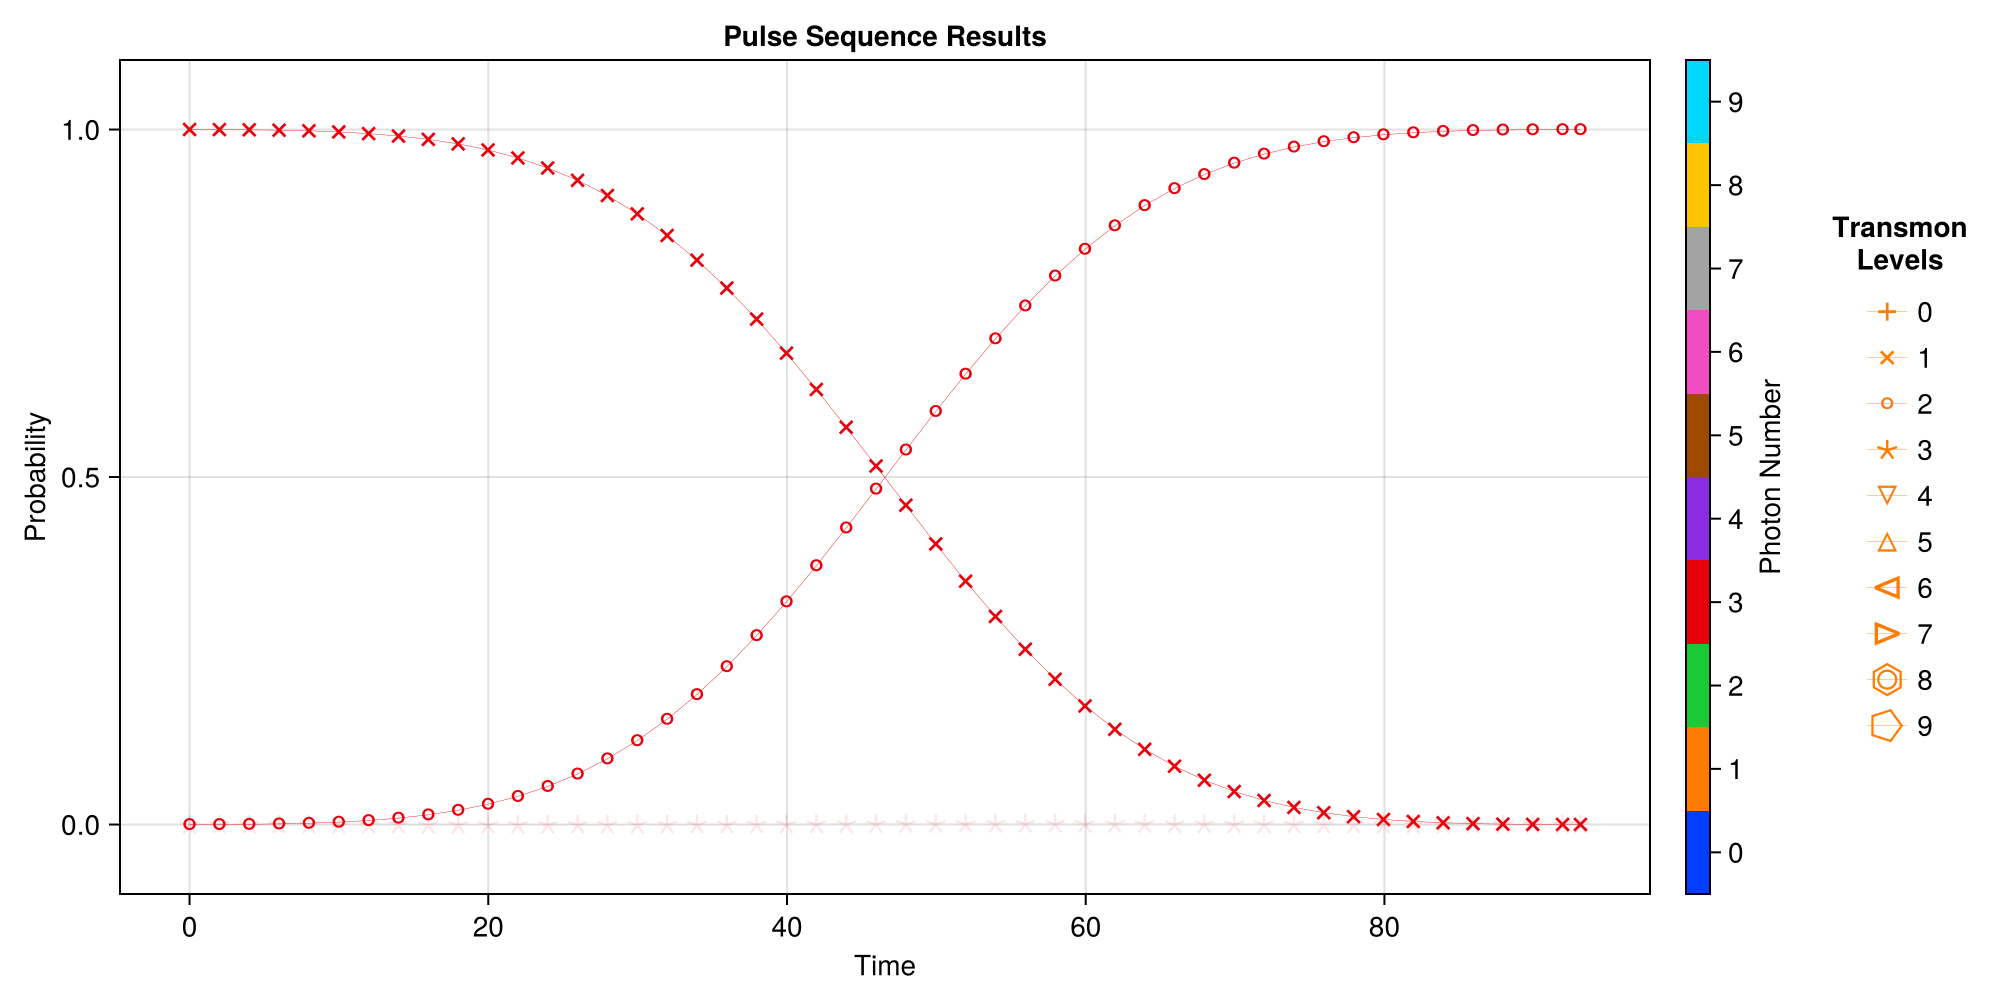

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [91]:
EVs[(2, 3)][end]

0.9998880859793374 - 1.0436987874152535e-17im

In [92]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999246614 - 1.0392036689936536e-17im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [ ]:
starting_args = deepcopy(Mode9.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode9.dressed_states[(0,0)]
ψ2 = Mode9.dressed_states[(0,0)] + Mode9.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode9.dressed_states[(0,0)]*Mode9.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-10 20:19:05] Info: On Level 1
[2024-11-10 20:19:05] Info: On Step 1: t = 92.96875
[2024-11-10 20:19:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:19:07] Info: Time Evolution Complete
[2024-11-10 20:19:07] Info: Done with Level_1_step_1
[2024-11-10 20:19:07] Info: Using Check Op
[2024-11-10 20:19:07] Info: Accurace: 0.9998445437881358
[2024-11-10 20:19:07] Info: ------------------------------------------------------------------------------
[2024-11-10 20:19:07] Info: Highest Accuracy: 0.9998445437881358
[2024-11-10 20:19:07] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-10 20:19:07] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999845
  "freq_d"        => 4.60406

In [ ]:
#Mode9.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999845
  "freq_d"        => 4.60406

In [ ]:
ψ = Mode9.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-10T20:19:07.207
It is being saved at: Data/
[2024-11-10 20:19:07] Info: Running operator q_half_ge0
[2024-11-10 20:19:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-10 20:19:09] Info: Time Evolution Complete
[2024-11-10 20:19:09] Info: Saving Steps
[2024-11-10 20:19:09] Info: Done with Step_1
[2024-11-10 20:19:09] Info: Done With Running Sequence
[2024-11-10 20:19:09] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [96]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-10 20:19:09] Info: Making Plot


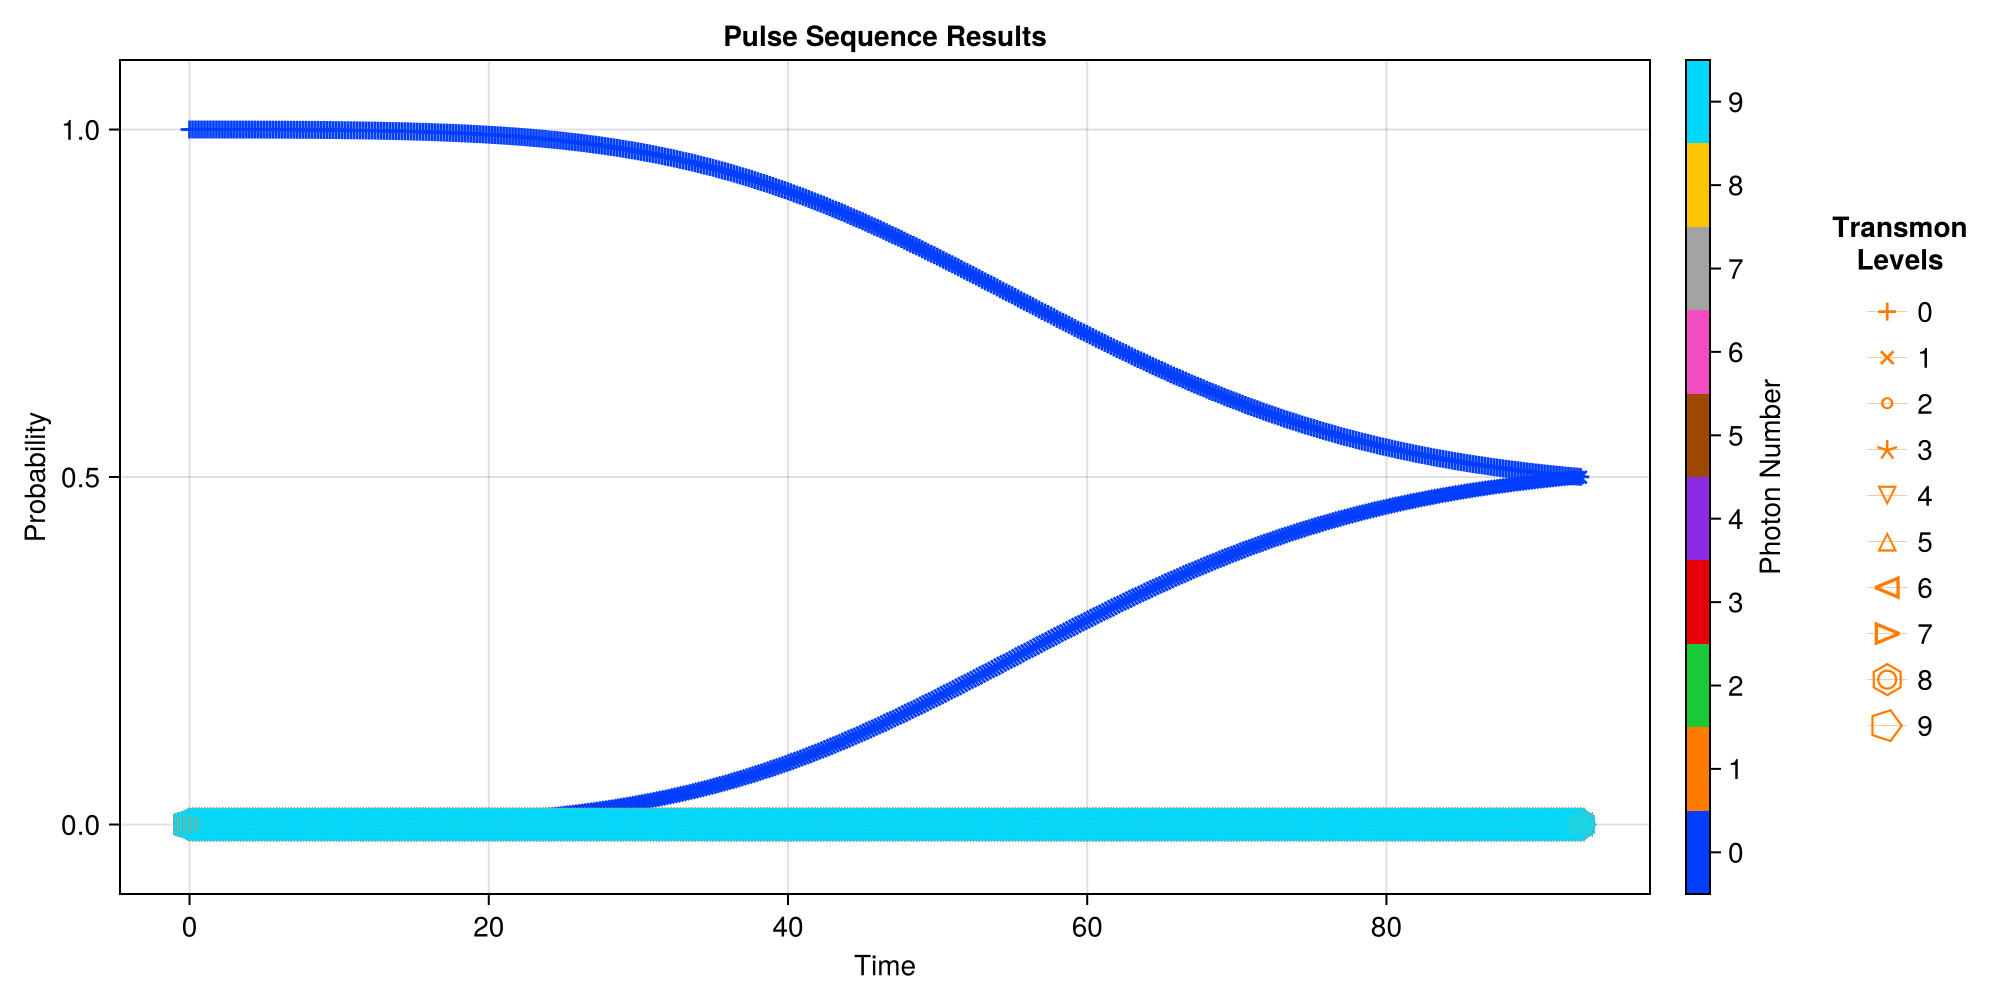

In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, res_half_ge0["times"], EVs_Dict);

In [98]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5001327115500607 + 3.327358490216552e-17im
0.4997119207842706 + 1.0496073065548359e-17im


In [ ]:
SC.Utils.save_model(Mode9)

## Sidebands at $\varepsilon = 1.68$

### Getting Stark Shift

[2024-11-11 12:00:25] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


[2024-11-11 12:00:50] Info: Done With Floquet Sweep
[2024-11-11 12:00:50] Info: Fit Stuff: 3-element Vector{Float64}:	 0.019398099766852146	 0.0013867550411383945	 2.0678280928115154
Stark shift res: [0.019398099766852146, 348.7271941551696]


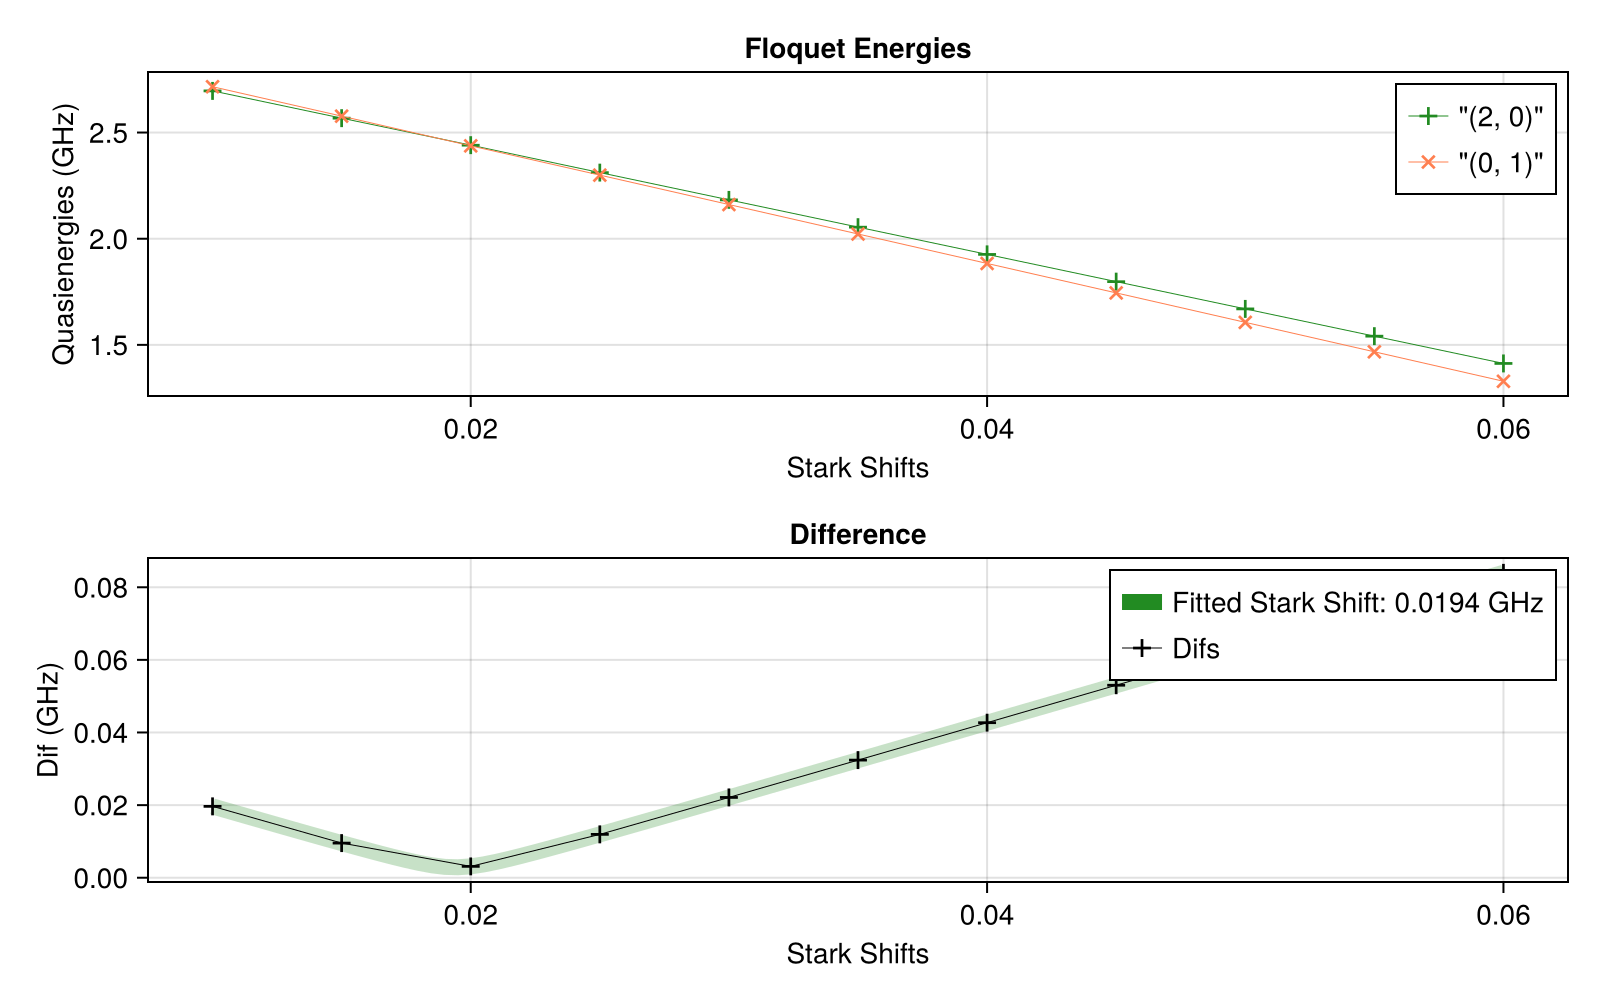

In [49]:
fngnp1_ε = 1.68
drive_op = Mode9.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode9, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [50]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [51]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][9][1]*1000))

Target flattop time: 338.6


In [52]:
ψ1 = Mode9.dressed_states[(2,0)]
ψ2 = Mode9.dressed_states[(0,1)]

freq_d = Mode9.dressed_energies[(0,1)]-Mode9.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:00:50] Info: On Level 1
[2024-11-11 12:00:50] Info: On Step 1: t = 348.7271941551696
[2024-11-11 12:00:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-11 12:00:58] Info: Time Evolution Complete
[2024-11-11 12:00:58] Info: Done with Level_1_step_1
[2024-11-11 12:00:58] Info: Accurace: 0.9965665180510322
[2024-11-11 12:00:58] Info: ------------------------------------------------------------------------------
[2024-11-11 12:00:58] Info: On Step 2: t = 354.54004415516965
[2024-11-11 12:00:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-11 12:01:05] Info: Time Evolution Complete
[2024-11-11 12:01:05] Info: Done with Level_1_step_2
[2024-11-11 12:01:05] Info: Accurace: 0.9989310763430367
[2024-11-11 12:01:05] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 361.806
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>361.806, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999975
  "freq_d"        => -1.38318

In [54]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

338.55470665516964

In [55]:
#Mode9.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 361.806
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>361.806, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999975
  "freq_d"        => -1.38318

In [56]:
ψ = Mode9.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:04:42.465
It is being saved at: Data/
[2024-11-11 12:04:42] Info: Running operator sb_f0g1
[2024-11-11 12:04:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 09s (ETA: 0h 00m 00s)
[2024-11-11 12:04:51] Info: Time Evolution Complete
[2024-11-11 12:04:51] Info: Saving Steps
[2024-11-11 12:04:56] Info: Done with Step_1
[2024-11-11 12:04:56] Info: Done With Running Sequence
[2024-11-11 12:04:56] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199893, 0.399786, 0.599679, 0.799572, 0.999464, 1.1993…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [57]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-11 12:05:00] Info: Making Plot


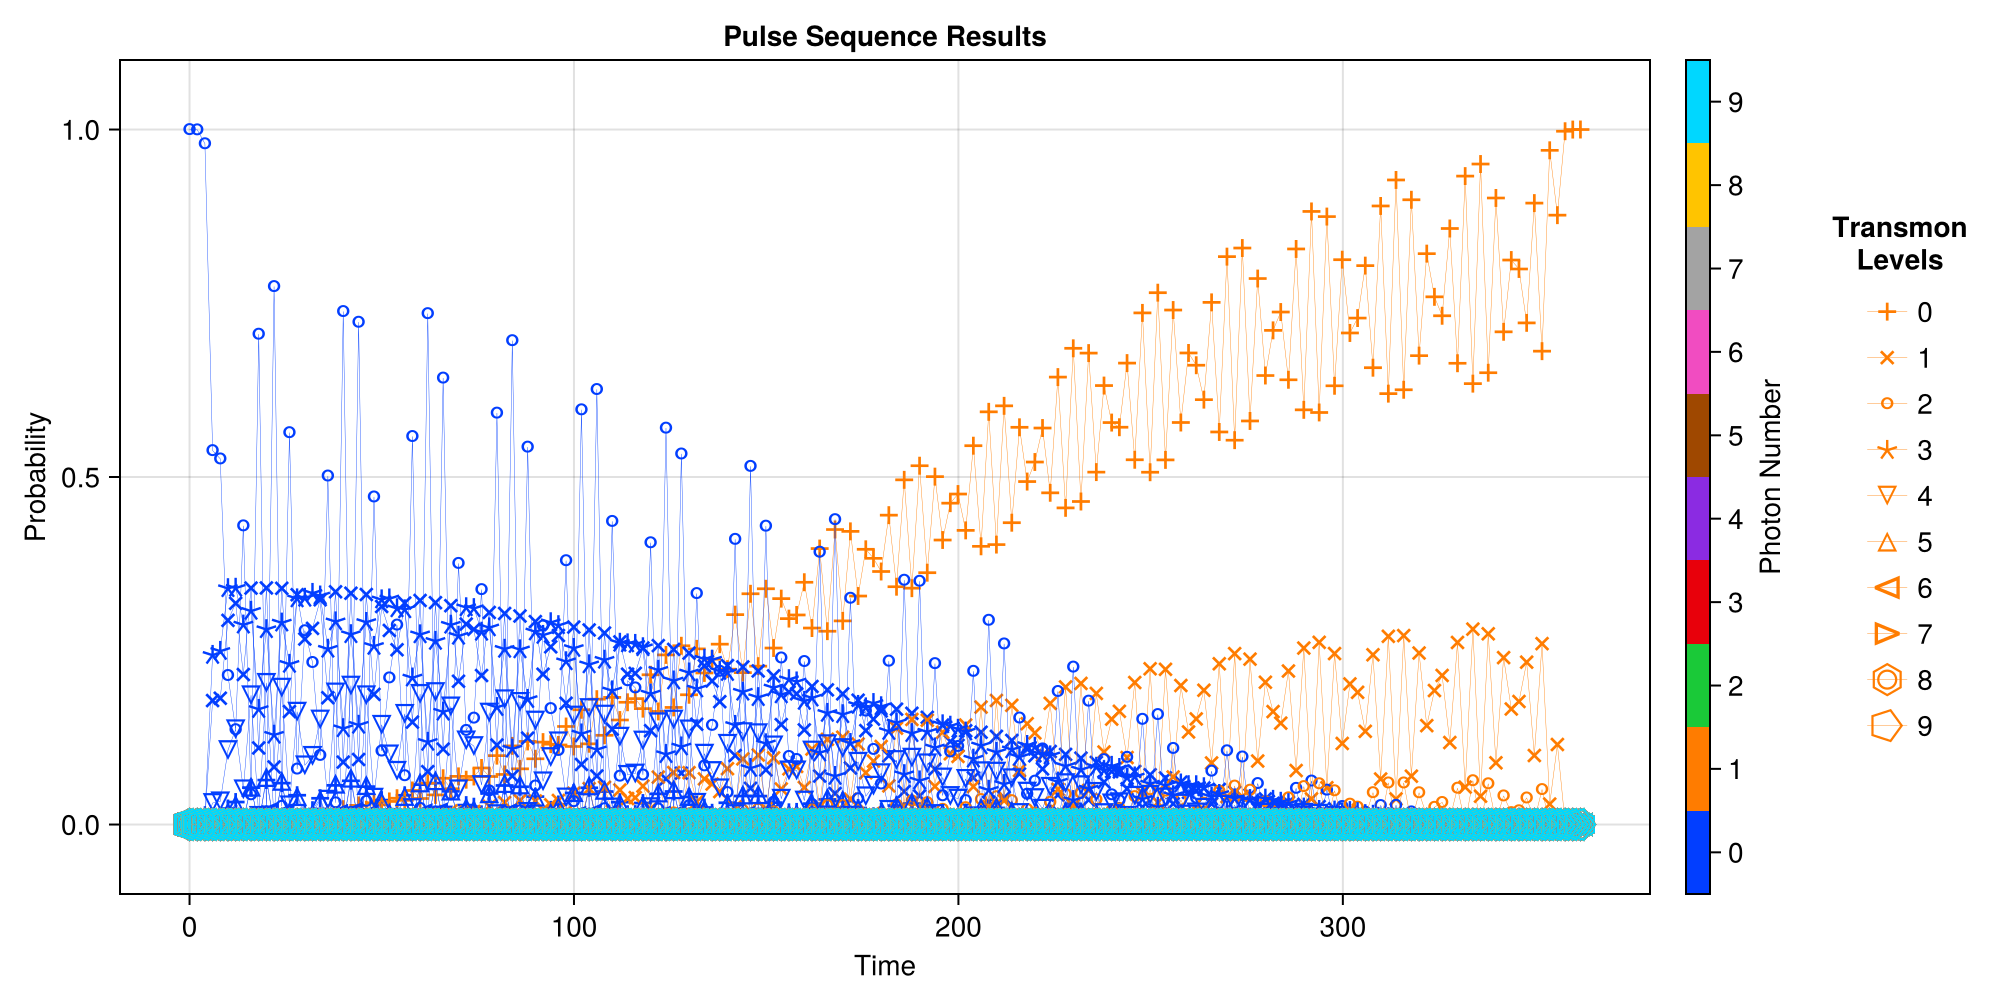

CairoMakie.Screen{IMAGE}


In [58]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [59]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][9][2]*1000))

Target flattop time: 246.1990248599697


In [60]:
ψ1 = Mode9.dressed_states[(2,1)]
ψ2 = Mode9.dressed_states[(0,2)]

freq_d = Mode9.dressed_energies[(0,2)]-Mode9.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:05:06] Info: On Level 1
[2024-11-11 12:05:06] Info: On Step 1: t = 246.58736377127818
[2024-11-11 12:05:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-11 12:05:10] Info: Time Evolution Complete
[2024-11-11 12:05:10] Info: Done with Level_1_step_1
[2024-11-11 12:05:10] Info: Accurace: 0.993348783168587
[2024-11-11 12:05:10] Info: ------------------------------------------------------------------------------
[2024-11-11 12:05:10] Info: On Step 2: t = 252.40021377127817
[2024-11-11 12:05:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-11 12:05:18] Info: Time Evolution Complete
[2024-11-11 12:05:18] Info: Done with Level_1_step_2
[2024-11-11 12:05:18] Info: Accurace: 0.9979326553629995
[2024-11-11 12:05:18] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 259.303
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>259.303, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999853
  "freq_d"        => -1.38296

In [61]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

236.0515731462782

In [62]:
#Mode9.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 259.303
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>259.303, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999853
  "freq_d"        => -1.38296

### f2->g3

In [63]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][9][3]*1000))

Target flattop time: 201.02066202590552


In [64]:
ψ1 = Mode9.dressed_states[(2,2)]
ψ2 = Mode9.dressed_states[(0,3)]

freq_d = Mode9.dressed_energies[(0,3)]-Mode9.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:07:45] Info: On Level 1
[2024-11-11 12:07:45] Info: On Step 1: t = 201.33773941923008
[2024-11-11 12:07:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-11 12:07:51] Info: Time Evolution Complete
[2024-11-11 12:07:51] Info: Done with Level_1_step_1
[2024-11-11 12:07:51] Info: Accurace: 0.9901546805979378
[2024-11-11 12:07:51] Info: ------------------------------------------------------------------------------
[2024-11-11 12:07:51] Info: On Step 2: t = 207.15058941923007
[2024-11-11 12:07:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-11 12:07:57] Info: Time Evolution Complete
[2024-11-11 12:07:57] Info: Done with Level_1_step_2
[2024-11-11 12:07:57] Info: Accurace: 0.9969308261043601
[2024-11-11 12:07:57] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 214.053
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>214.053, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999704
  "freq_d"        => -1.38274

In [65]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

190.80194879423007

In [66]:
#Mode9.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 214.053
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>214.053, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.999704
  "freq_d"        => -1.38274

### f3->g4

In [67]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][9][4]*1000))

Target flattop time: 174.089


In [68]:
ψ1 = Mode9.dressed_states[(2,3)]
ψ2 = Mode9.dressed_states[(0,4)]

freq_d = Mode9.dressed_energies[(0,4)]-Mode9.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:10:11] Info: On Level 1
[2024-11-11 12:10:11] Info: On Step 1: t = 174.3635970775848
[2024-11-11 12:10:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-11 12:10:16] Info: Time Evolution Complete
[2024-11-11 12:10:16] Info: Done with Level_1_step_1
[2024-11-11 12:10:16] Info: Accurace: 0.9869808733721328
[2024-11-11 12:10:16] Info: ------------------------------------------------------------------------------
[2024-11-11 12:10:16] Info: On Step 2: t = 180.1764470775848
[2024-11-11 12:10:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-11 12:10:21] Info: Time Evolution Complete
[2024-11-11 12:10:21] Info: Done with Level_1_step_2
[2024-11-11 12:10:21] Info: Accurace: 0.9959335170364982
[2024-11-11 12:10:21] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 186.716
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>186.716, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.99955
  "freq_d"        => -1.38252

In [69]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

163.46450332758482

In [70]:
#Mode9.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 186.716
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>186.716, "k"=>2, "ramp_time"=…
  "epsilon"       => 1.68
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0193981
  "accuracy"      => 0.99955
  "freq_d"        => -1.38252

In [71]:
SC.Utils.save_model(Mode9)

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 1
n2 = 3

freq1 = Mode9.dressed_energies[(2,n1)]-Mode9.dressed_energies[(0,n1+1)]
freq2 = Mode9.dressed_energies[(2,n2)]-Mode9.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.3
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007848970006136824
m: 1.4142135623730951
n: 1
Required Epsilon: 0.0832508987500375


[2024-11-08 18:41:51] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[2024-11-08 18:42:12] Info: Done With Floquet Sweep
[2024-11-08 18:42:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0007613188025463708	 0.0005267568261410399	 2.0028257671502483


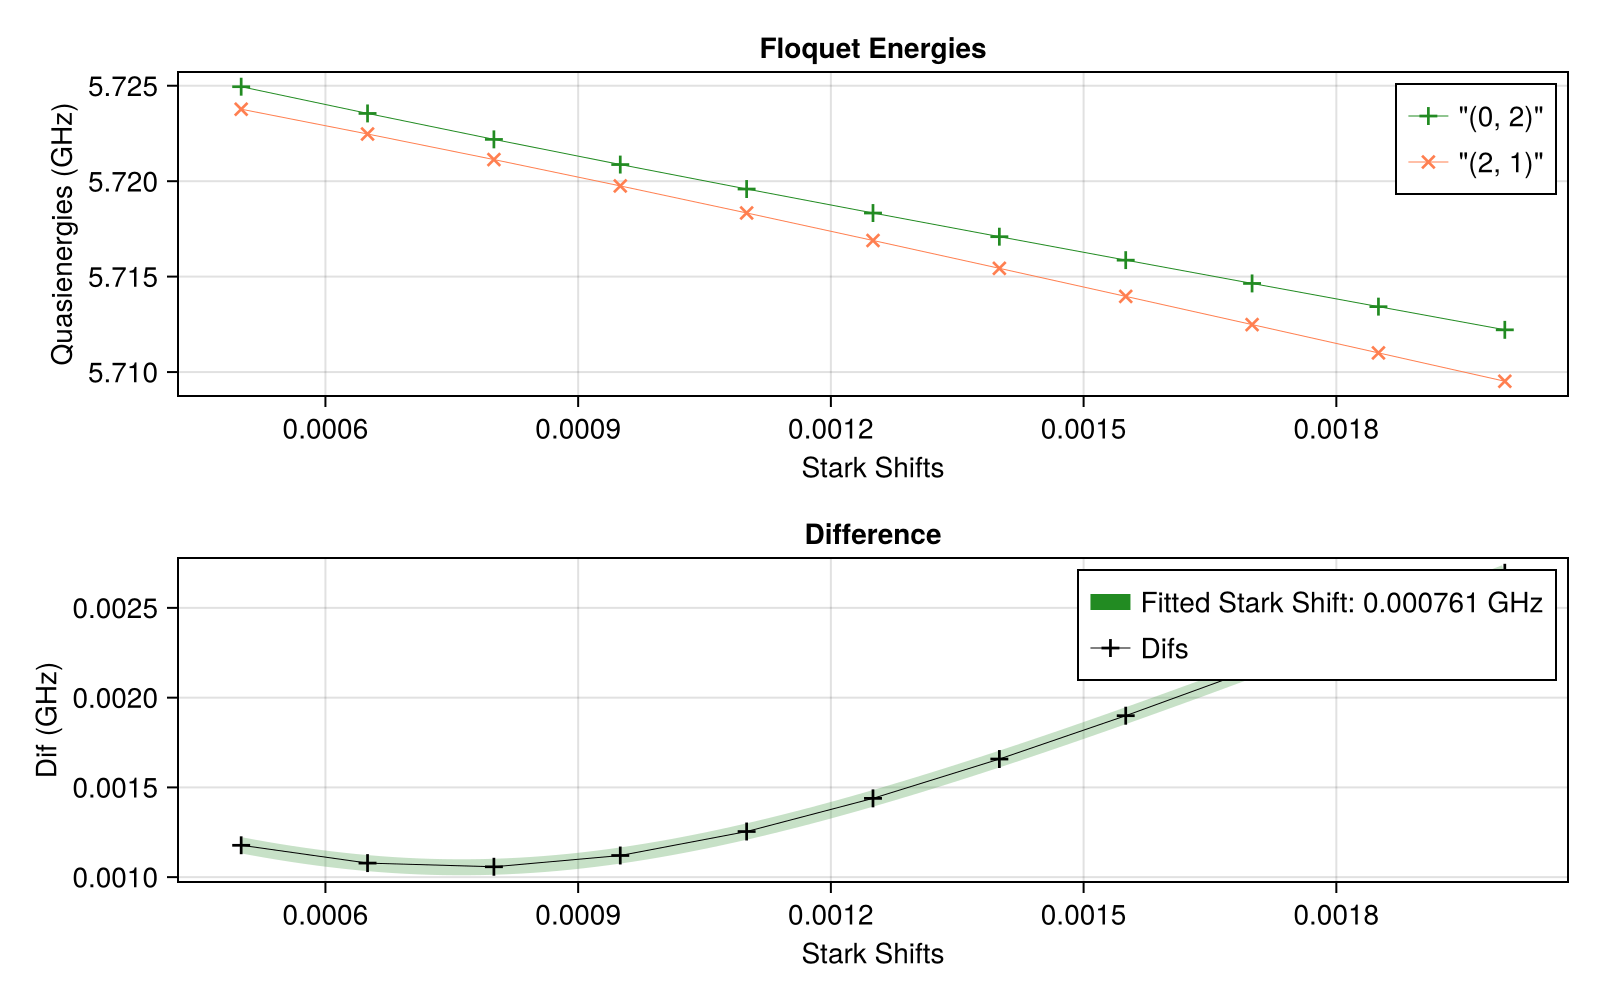

2-element Vector{Float64}:
   0.0007613188025463708
 947.8653719249797

In [ ]:
ε = eps_f1_2pi_g3
drive_op = Mode9.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode9, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [17]:
n2

3

In [ ]:
ψ1 = Mode9.dressed_states[(2,n1)]+Mode9.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode9.dressed_states[(0,n1+1)]+Mode9.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode9.dressed_energies[(0,n1+1)]-Mode9.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode9.dressed_states[(0,n1+1)]*Mode9.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 18:42:12] Info: On Level 1
[2024-11-08 18:42:12] Info: On Step 1: t = 938.38671820573
[2024-11-08 18:42:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2024-11-08 18:42:55] Info: Time Evolution Complete
[2024-11-08 18:42:55] Info: Done with Level_1_step_1
[2024-11-08 18:42:55] Info: Using Check Op
[2024-11-08 18:42:55] Info: Accurace: 0.9993598958222756
[2024-11-08 18:42:55] Info: ------------------------------------------------------------------------------
[2024-11-08 18:42:55] Info: On Step 2: t = 941.5462694454799
[2024-11-08 18:42:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 43s (ETA: 0h 00m 00s)
[2024-11-08 18:43:39] Info: Time Evolution Complete
[2024-11-08 18:43:39] Info: Done with Level_1_step_2
[2024-11-08 18:43:39] Info: Using Check Op
[2024-11-08 18:43:39] Info: Accurace: 0.9994618631727932
[2024-11-08 18:43:39] Info: 

In [19]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

921.4544206852298

In [ ]:
#Mode9.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 944.706
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>944.706, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0832509
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000761319
  "accuracy"      => 0.999482
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode9.dressed_states[(2,1)]+Mode9.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:48:49.463
It is being saved at: Data/
[2024-11-08 18:48:49] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:48:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-08 18:49:30] Info: Time Evolution Complete
[2024-11-08 18:49:30] Info: Saving Steps
[2024-11-08 18:49:37] Info: Done with Step_1
[2024-11-08 18:49:37] Info: Done With Running Sequence
[2024-11-08 18:49:37] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19998, 0.39996, 0.59994, 0.79992, 0.9999, 1.19988, 1.3…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:49:42] Info: Making Plot


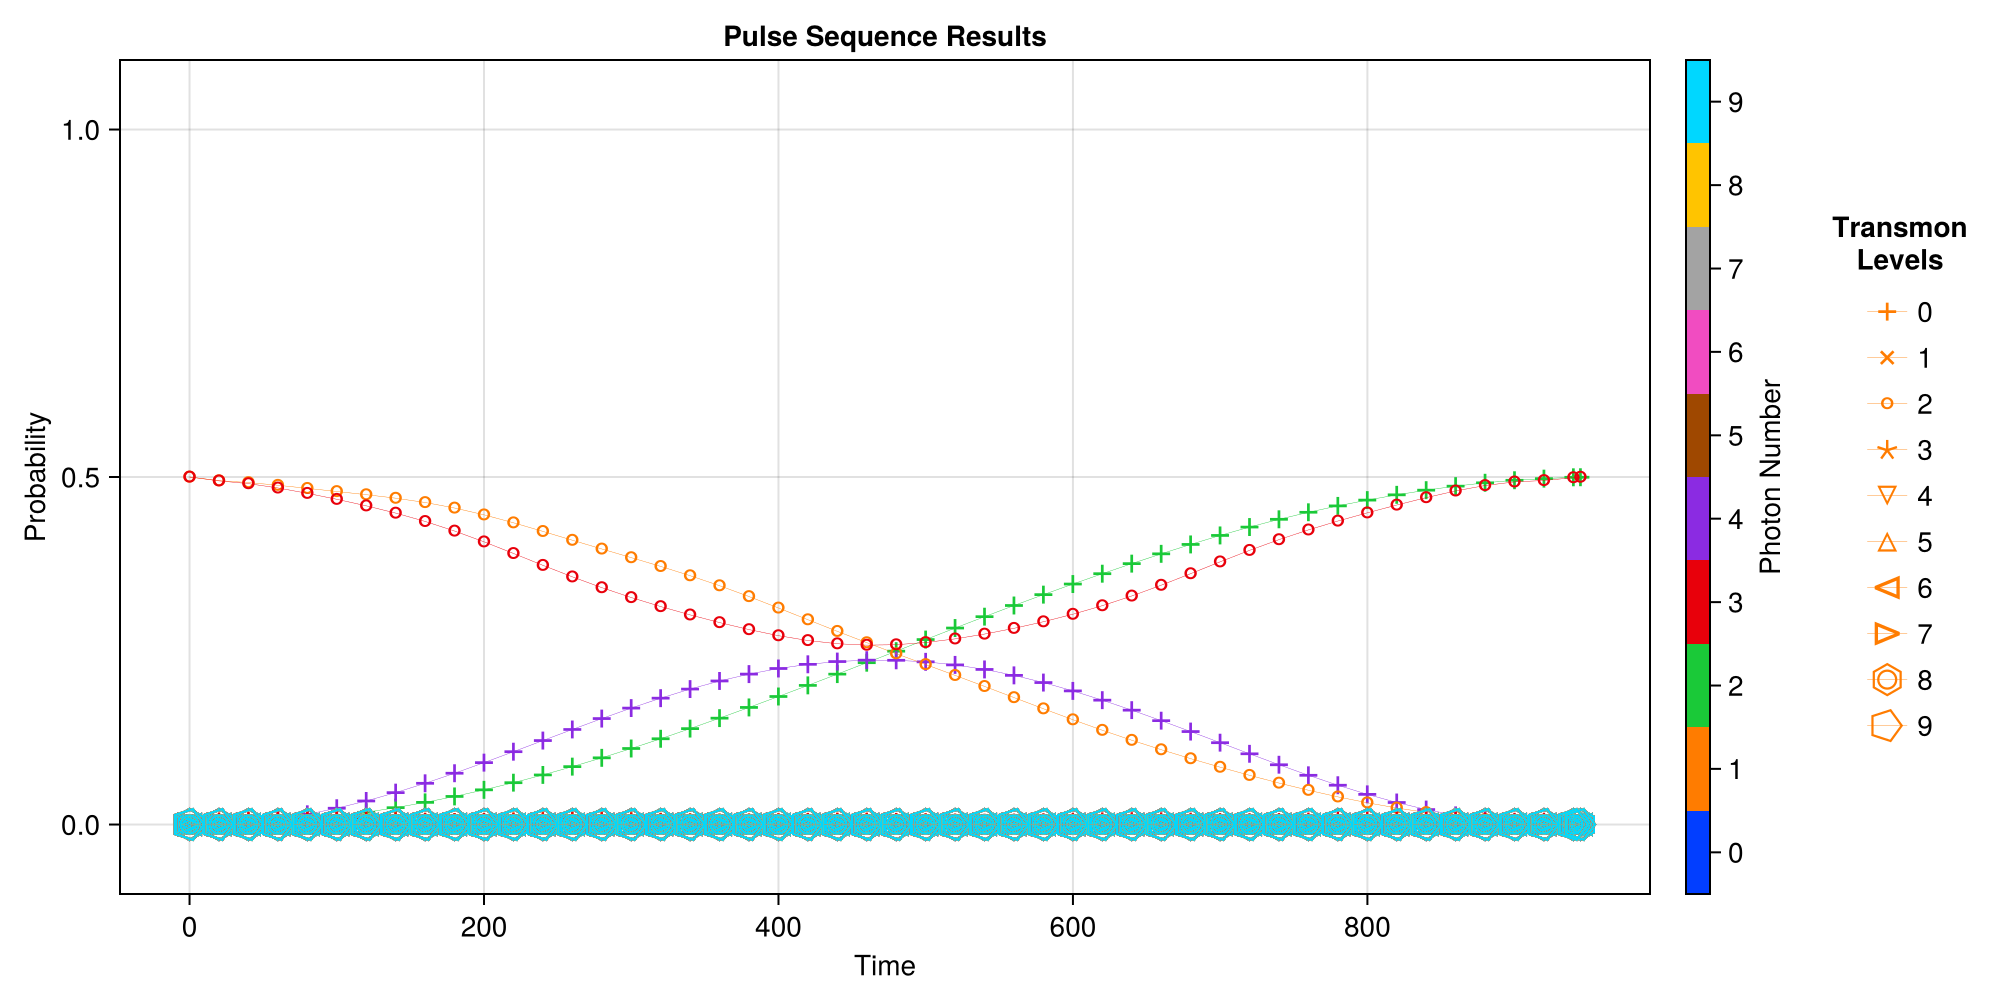

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [24]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.49979117254934646 + 4.706245818708166e-17im
0.4996905168282355 + 6.065084884910372e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 0
n2 = 3

freq1 = Mode9.dressed_energies[(2,n1)]-Mode9.dressed_energies[(0,n1+1)]
freq2 = Mode9.dressed_energies[(2,n2)]-Mode9.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.001177480925420582
m: 2.0000000000000004
n: 2
Required Epsilon: 0.07647962954143757


[2024-11-08 18:55:07] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-08 18:55:29] Info: Done With Floquet Sweep
[2024-11-08 18:55:29] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006433530530826274	 0.0003423902156711056	 2.002387126418146


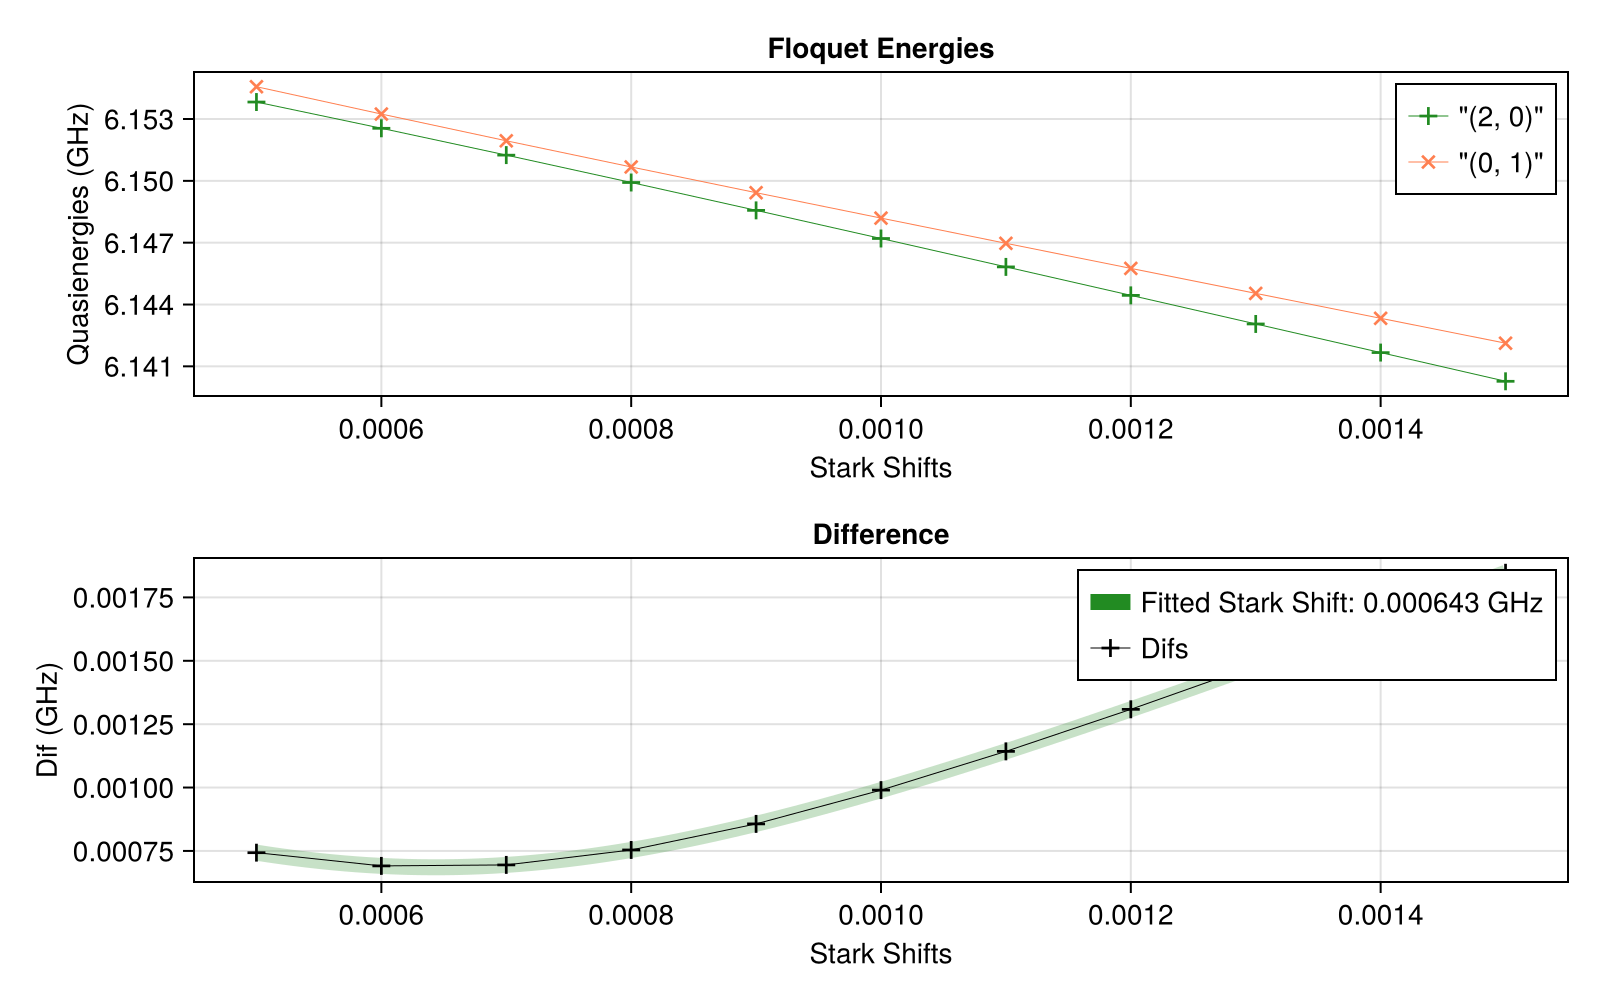

2-element Vector{Float64}:
    0.0006433530530826274
 1458.5811947459163

In [ ]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode9.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode9, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [ ]:
ψ1 = Mode9.dressed_states[(2,n1)]+Mode9.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode9.dressed_states[(0,n1+1)]+Mode9.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode9.dressed_energies[(0,n1+1)]-Mode9.dressed_energies[(2, n1)]

check_op = 2*Mode9.dressed_states[(0,n1+1)]*Mode9.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-08 18:55:29] Info: On Level 1
[2024-11-08 18:55:29] Info: On Step 1: t = 1458.5811947459163
[2024-11-08 18:55:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:56:41] Info: Time Evolution Complete
[2024-11-08 18:56:41] Info: Done with Level_1_step_1
[2024-11-08 18:56:41] Info: Using Check Op
[2024-11-08 18:56:41] Info: Accurace: 0.9986803501131906
[2024-11-08 18:56:41] Info: ------------------------------------------------------------------------------
[2024-11-08 18:56:41] Info: On Step 2: t = 1481.8325947459164
[2024-11-08 18:56:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:57:57] Info: Time Evolution Complete
[2024-11-08 18:57:57] Info: Done with Level_1_step_2
[2024-11-08 18:57:57] Info: Using Check Op
[2024-11-08 18:57:57] Info: Accurace: 0.999820378239168
[2024-11-08 18:57:57] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
#Mode9.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
ψ = Mode9.dressed_states[(2,0)]+Mode9.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T18:58:08.288
It is being saved at: Data/
[2024-11-08 18:58:08] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 18:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 03s (ETA: 0h 00m 00s)
[2024-11-08 18:59:12] Info: Time Evolution Complete
[2024-11-08 18:59:12] Info: Saving Steps
[2024-11-08 18:59:12] Info: Done with Step_1
[2024-11-08 18:59:12] Info: Done With Running Sequence
[2024-11-08 18:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999887, 1.99977, 2.99966, 3.99955, 4.99944, 5.99932, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-08 18:59:13] Info: Making Plot


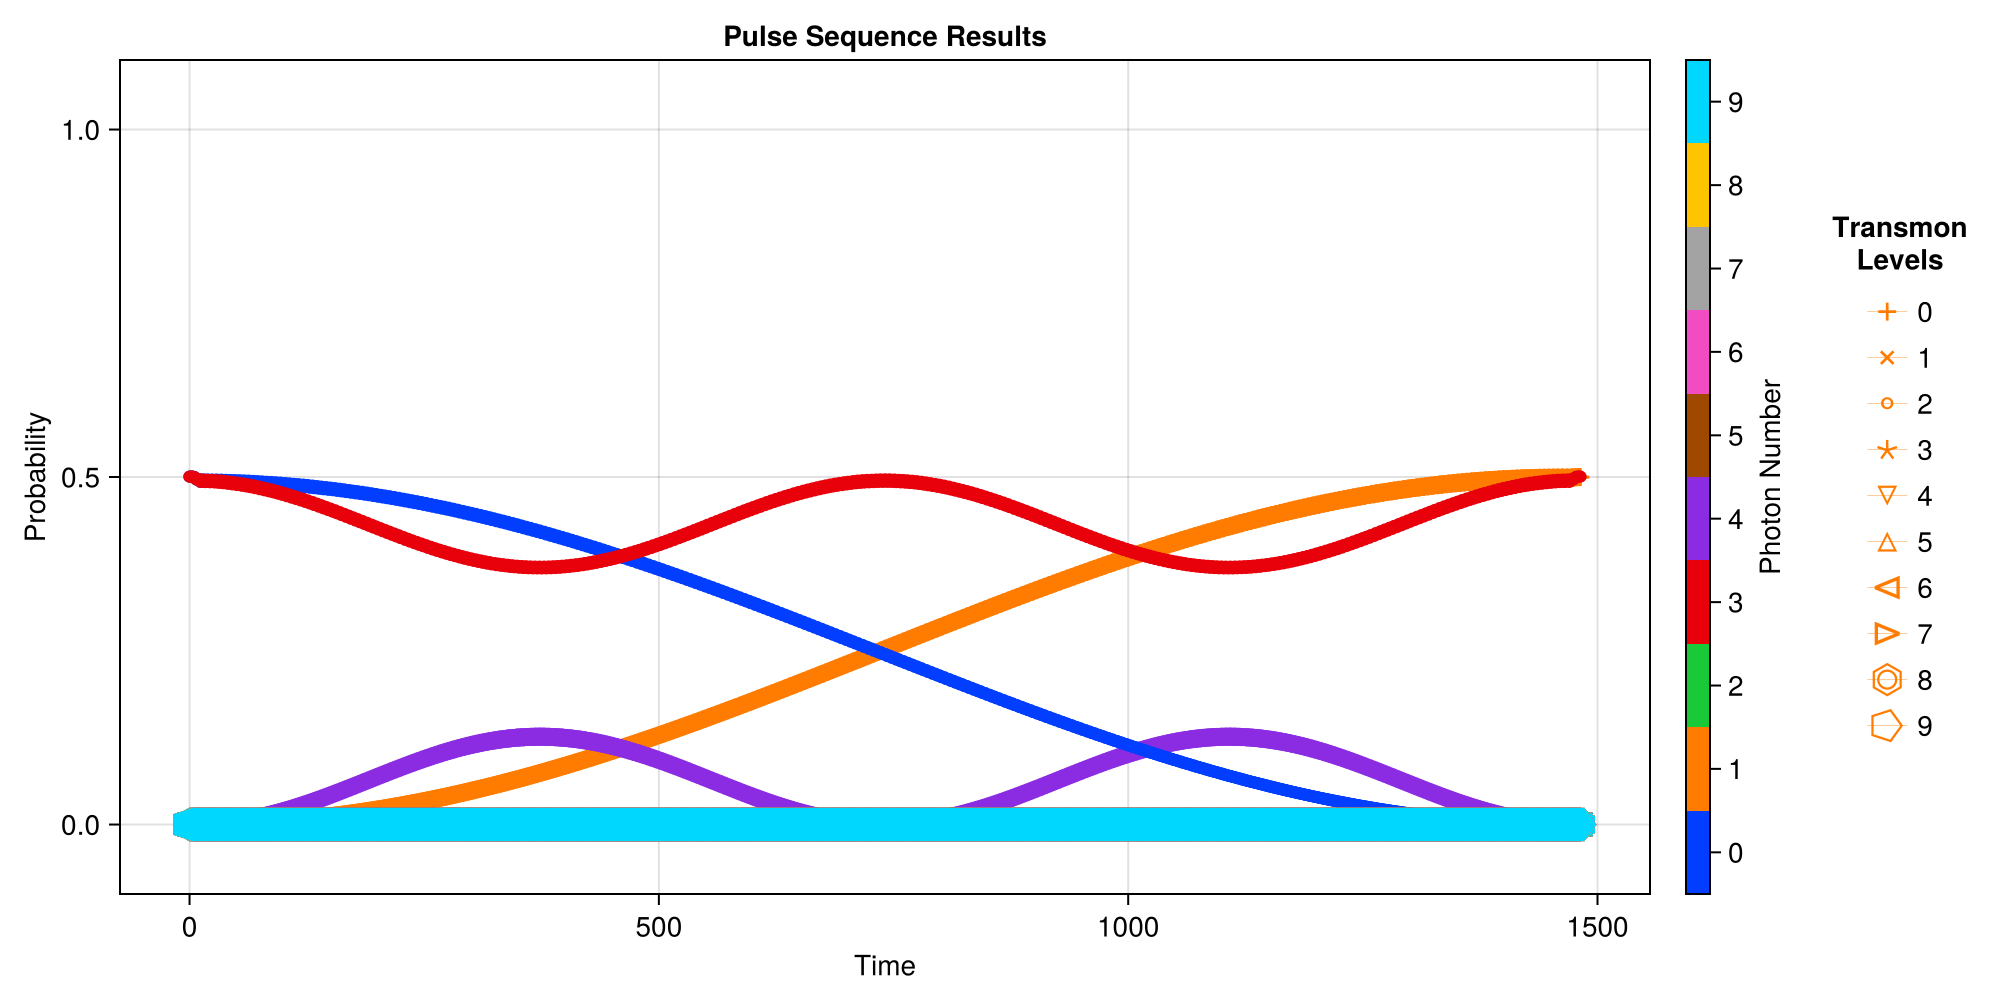

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [37]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999974818391036 + 3.209912380096676e-17im
0.4998153296675962 + 8.967827678057819e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [ ]:
Mode9.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.67000432799944

In [ ]:
starting_args = deepcopy(Mode9.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode9.dressed_states[(2,1)]
ψ2 = Mode9.dressed_states[(2,1)] + Mode9.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode9.dressed_states[(2,1)]*Mode9.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.7]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode9, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 19:02:02] Info: On Level 1
[2024-11-08 19:02:02] Info: On Step 1: t = 74.33500216399972
[2024-11-08 19:02:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:02:07] Info: Time Evolution Complete
[2024-11-08 19:02:07] Info: Done with Level_1_step_1
[2024-11-08 19:02:07] Info: Using Check Op
[2024-11-08 19:02:07] Info: Accurace: 0.9903045931640259
[2024-11-08 19:02:07] Info: ------------------------------------------------------------------------------
[2024-11-08 19:02:07] Info: On Step 2: t = 75.57391886673305
[2024-11-08 19:02:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 19:02:11] Info: Time Evolution Complete
[2024-11-08 19:02:11] Info: Done with Level_1_step_2
[2024-11-08 19:02:11] Info: Using Check Op
[2024-11-08 19:02:11] Info: Accurace: 0.9938610397870073
[2024-11-08 19:02:11] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
#Mode9.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode9.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode9.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode9, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T19:03:32.612
It is being saved at: Data/
[2024-11-08 19:03:32] Info: Running operator sb_half_f1g2
[2024-11-08 19:03:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:03:36] Info: Time Evolution Complete
[2024-11-08 19:03:36] Info: Saving Steps
[2024-11-08 19:03:37] Info: Done with Step_1
[2024-11-08 19:03:37] Info: Done With Running Sequence
[2024-11-08 19:03:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199825, 0.399651, 0.599476, 0.799301, 0.999126, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [56]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 19:03:38] Info: Making Plot


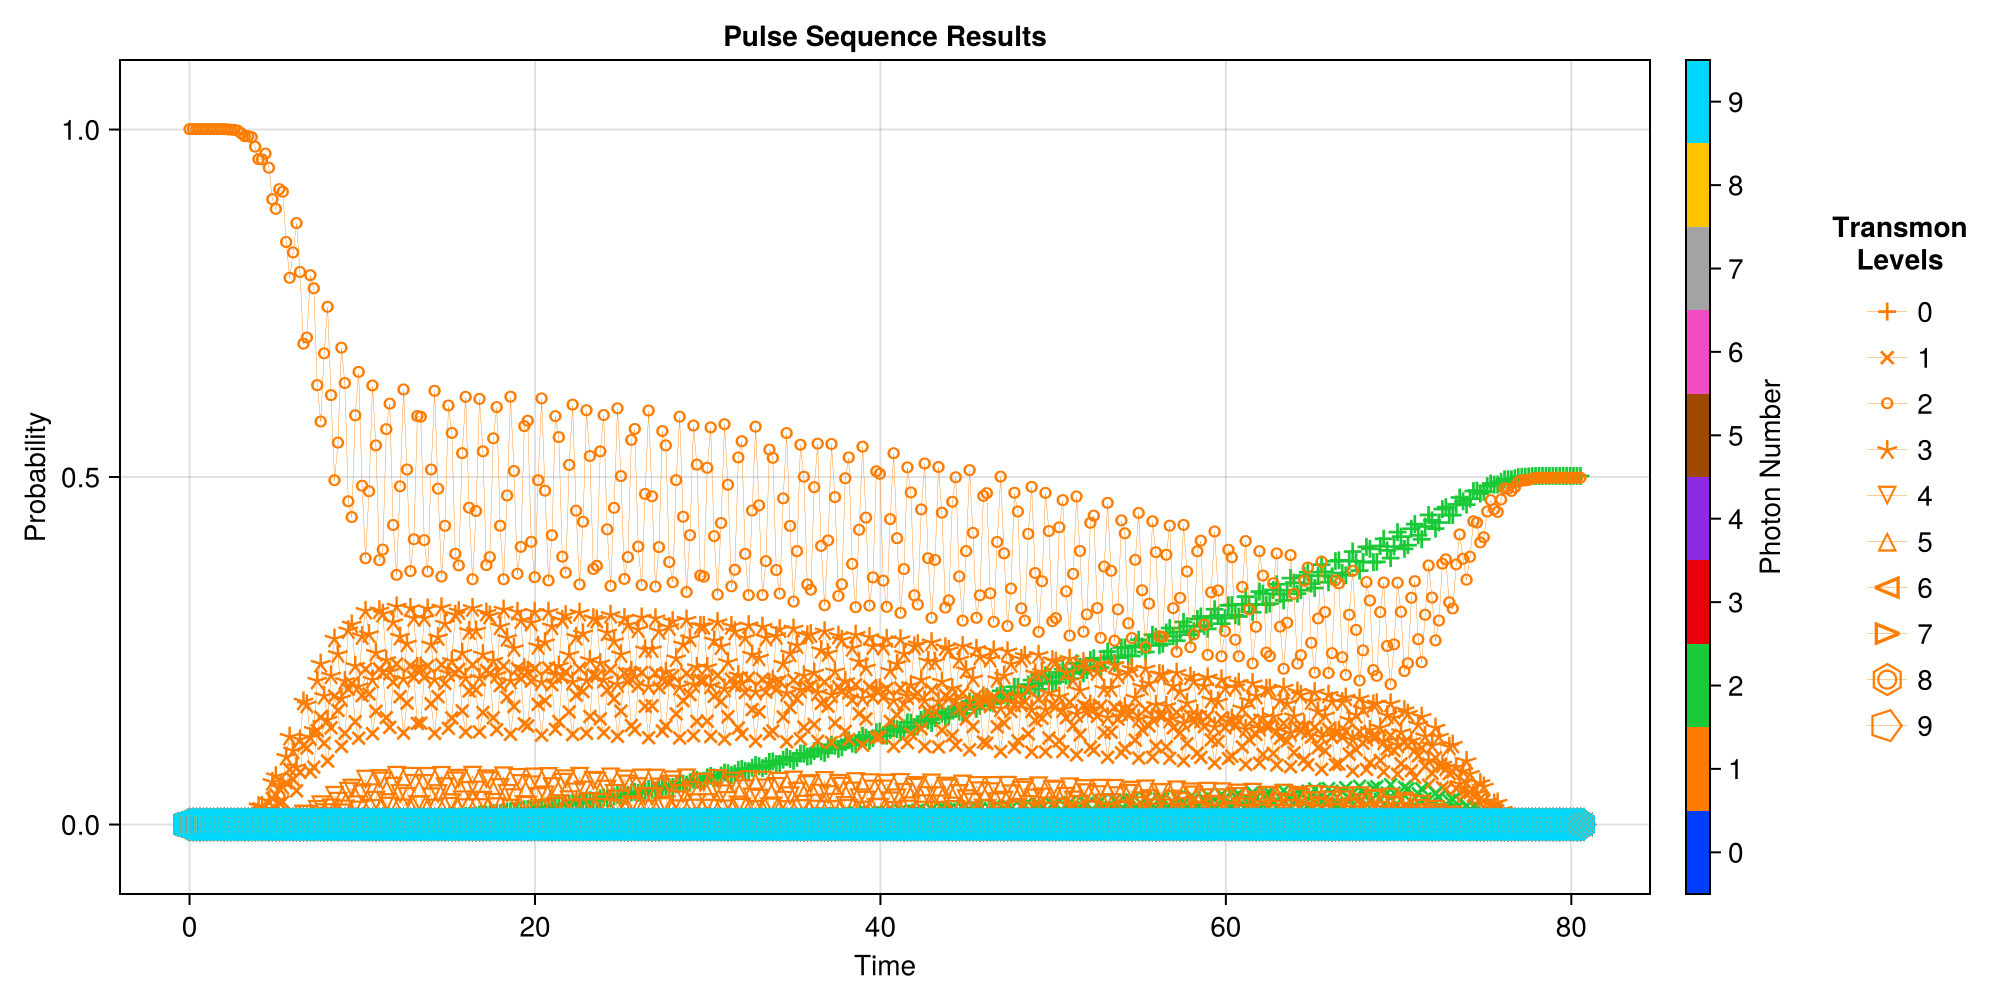

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode9, res_half_f1g2["times"], EVs_Dict)

In [58]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49842784624199354 + 3.047257166760866e-18im
0.5015715525412404 - 3.656046931258164e-17im
